# **Reconocimiento de patrones de electroencefalografía relacionados con fatiga y alta carga mental en conductores utilizando algoritmos de Inteligencia Artificial**


#### Elaborado por: Luis Arturo Franceschi Jimenez

En este proyecto se realiza un análisis de diferentes modelos de aprendizaje de máquina y aprendizaje profundo utilizando dos bases de datos obtenidos por Min et al. (2017) en un estudio de detección de fatiga en conductores ([Artículo](https://journals.plos.org/plosone/article?id=10.1371/journal.pone.0188756#pone.0188756.ref040)).

Estas dos bases de datos recopiladas por el grupo de investigación contienen:

1) Datos crudos de Electroencefalografía (EEG) recopilados durante detección de fatiga en conductores ([Base de Datos](https://figshare.com/articles/dataset/The_raw_EEG_recordings_used_for_detecting_driver_fatigue_/27926826))

2) 50% de los datos crudos de EEG procesados en 4 entropias ([Base de Datos](https://figshare.com/articles/dataset/The_entropy_value_for_driver_fatigue_detection/5202751))

Este proyecto tiene tres objetivos principales:

1) Replicar los procesamientos de los datos y las arquitecturas utilizadas.
2) Aplicar modelos de aprendizaje profundo.
3) Escoger la mejor arquitectura para utilizar en un próximo sistema de detección de fatiga en conductores.

## Libreria y Manejo de Google Drive

In [ ]:
# Para traer la versión necesaria de MNE
!pip install mne==1.3.0

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 13.1 MB/s eta 0:00:00


In [ ]:
# Instalar mne-features para las entropías
!pip install mne-features

In [ ]:
# Conexión en colab
from google.colab import drive
from google.colab import files
drive.mount('/content/drive/')

# Carpeta en mi drive donde están los datos del proyecto 
%cd /content/drive/MyDrive/....
%pwd

Mounted at /content/drive/
/content/drive/MyDrive/Proyecto Final Diplomado


'/content/drive/MyDrive/Proyecto Final Diplomado'

In [ ]:
# Cargamos las librerias que se usarán:

# Librerías de manejo de datos:
import os
import pickle
import numpy as np
import pandas as pd
from scipy.io import loadmat

# Librerías de visualización:
import matplotlib.pyplot as plt

# Librerías de procesamiento de EEG:
import mne
from mne_features.univariate import compute_spect_entropy, compute_samp_entropy, compute_app_entropy

# Librerías de Machine Learning en Sci-kit Learn:
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report

# Librerías de Deep Learning con TensorFlow y Keras:
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.layers import Dense, Dropout, Input, Average, Layer, Multiply, Conv1D, MaxPooling1D, LSTM, BatchNormalization
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam

## Datos de Entropía

La base de Datos de Entropía solo contiene el 50% de los datos porque es lo que el equipo de investigación designó como datos de entrenamiento, reservandose sus datos de pruebas. De estos datos, usaremos el 80% para entrenar y 20% para prueba.

Estos datos contienen 4 tipos de entropia en 30 canales por 12 sujetos.

In [ ]:
# listas para almacenar los datos y etiquetas
X_list = []
y_list = []
# 1 Fatiga, 0 Normal

# Ruta a los archivos
ruta = 'DataBase2Entropies'

# Función de min-max para estandarizar
def min_max_scale(arr):
    min_val = np.min(arr, axis=0)
    max_val = np.max(arr, axis=0)
    # Evitar división por cero
    range_val = max_val - min_val
    range_val[range_val == 0] = 1e-8
    return (arr - min_val) / range_val

for i in range(1, 13):
    data = loadmat(os.path.join(ruta, f'{i}.mat'))

    # Escalar cada entropía por separado
    #fe = min_max_scale(data['FE'])  # (n_muestras, 30)
    se = min_max_scale(data['SE'])
    #ae = min_max_scale(data['AE'])
    pe = min_max_scale(data['PE'])

    # Concatenar horizontalmente (n_muestras, 120)
    X = np.concatenate([se, pe], axis=1) #[fe, se, ae, pe]
    print("Sujeto ",i)
    print(np.shape(X))

    # Etiquetas
    y = data['Class_label'].ravel()  # (n_muestras,)

    X_list.append(X)
    y_list.append(y)

# Unir todos los sujetos
X_total_mitad = np.vstack(X_list)
y_total_mitad = np.concatenate(y_list)

Sujeto  1
(300, 60)
Sujeto  2
(299, 60)
Sujeto  3
(302, 60)
Sujeto  4
(301, 60)
Sujeto  5
(300, 60)
Sujeto  6
(301, 60)
Sujeto  7
(300, 60)
Sujeto  8
(300, 60)
Sujeto  9
(301, 60)
Sujeto  10
(300, 60)
Sujeto  11
(300, 60)
Sujeto  12
(301, 60)


In [ ]:
print(np.shape(X_total_mitad)) # 120 = La combinación de los 30 electrodos x 4 entropias
print(np.shape(y_total_mitad))
# La mitad de los datos reales
#432,600

(3605, 60)
(3605,)


## Análisis ML1: Pruebas con modelos reportados en el artículo

1) Backpropagation Neural Network

2) Random Forest

3) Support Vector Machine

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_total_mitad, y_total_mitad, test_size=0.2, stratify=y_total_mitad, random_state=42)

# Modelos con lineamientos del articulo
clf = MLPClassifier(
    hidden_layer_sizes=(20,),  # Una capa oculta con 20 neuronas
    activation='logistic',     # Función sigmoide ('logistic' en sklearn)
    solver='lbfgs',            # Alternativa a Levenberg–Marquardt
    max_iter=500,
    random_state=42
)
clf.fit(X_train, y_train)

# BPNN
y_pred = clf.predict(X_test)
print("Backpropagation Neural Network")
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n",classification_report(y_test, y_pred))

# Random Forest
rf = RandomForestClassifier(
    n_estimators=200,   # Número de arboles
    max_features = 22,   # Número de featues considerados en cada split
    random_state=42
    )
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)
print("Random Forest")
print("Accuracy:", accuracy_score(y_test, y_pred_rf))
print("Classification Report:\n", classification_report(y_test, y_pred_rf))

# SVM del artículo
svm_paper = SVC(kernel='rbf',
          C = 2**(-1), # c = -1
          gamma = 2**(-5), # g = -5
          random_state=42)
svm_paper.fit(X_train, y_train)
y_pred_svm_paper = svm_paper.predict(X_test)
print("Support Vector Machine | Artículo")
print("Accuracy:", accuracy_score(y_test, y_pred_svm_paper))
print("Classification Report:\n", classification_report(y_test, y_pred_svm_paper))

# SVM sin hiperparametros del artículo
svm = SVC(kernel='rbf',random_state=42)
svm.fit(X_train, y_train)
y_pred_svm = svm.predict(X_test)
print("Support Vector Machine | Default")
print("Accuracy:", accuracy_score(y_test, y_pred_svm))
print("Classification Report:\n", classification_report(y_test, y_pred_svm))

/usr/local/lib/python3.12/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


Backpropagation Neural Network
Accuracy: 0.9084604715672677
Classification Report:
               precision    recall  f1-score   support

           0       0.90      0.92      0.91       360
           1       0.92      0.90      0.91       361

    accuracy                           0.91       721
   macro avg       0.91      0.91      0.91       721
weighted avg       0.91      0.91      0.91       721

Random Forest
Accuracy: 0.912621359223301
Classification Report:
               precision    recall  f1-score   support

           0       0.91      0.91      0.91       360
           1       0.91      0.91      0.91       361

    accuracy                           0.91       721
   macro avg       0.91      0.91      0.91       721
weighted avg       0.91      0.91      0.91       721

Support Vector Machine | Artículo
Accuracy: 0.8363384188626907
Classification Report:
               precision    recall  f1-score   support

           0       0.86      0.80      0.83       360


## Datos de EEG crudos

La base de datos incluye 10 minutos de señal EEG de 12 participantes para un estado normal y uno de fatiga de conducción, registrados en 40 electrodos (38 cerebrales, 4 oculares y 2 de referencia en los lobulos de cada oreja) a una frecuencia de muestreo de 1000 Hz.


### Canales

40 canales: ('HEOL', 'HEOR', 'FP1', 'FP2', 'VEOU', 'VEOL', 'F7', 'F3', 'FZ', 'F4', 'F8', 'FT7', 'FC3', 'FCZ', 'FC4', 'FT8', 'T3', 'C3', 'CZ', 'C4', 'T4', 'TP7', 'CP3', 'CPZ', 'CP4', 'TP8', 'A1', 'T5', 'P3', 'PZ', 'P4', 'T6', 'A2', 'O1', 'OZ', 'O2', 'FT9', 'FT10', 'PO1', 'PO2')

Ahora bien, como la idea es usar en un sistema a futuro con el dispositivo The Crown de [Neurosity](https://journals.plos.org/plosone/article?id=10.1371/journal.pone.0188756#pone.0188756.ref040), tomaremos de la base de datos los canales que presenta el dispositivo y aquellos con mayor cercanía.

| Canal | ¿Está en la BD? | Canal Cercano |
| ----- | ------------------ | ----- |
| CP3   | Sí              | |
| C3    | Sí               ||
| F5    | No               |F3 o F7|
| PO3   | No               |PO1 o O1|
| PO4   | No               |PO2 o O2|
| F6    | No               |F4 o F8|
| C4    | Sí               ||
| CP4   | Sí               ||

## Lectura de datos de EEG, Preprocesamiento y Procesamiento de Entropias

- Filtros: Notch a 50Hz y Pasa-banda de 0.15Hz a 45Hz
- Filtro especial de Re-Referencia Común Promedio (CAR)
- Segmentación: 6 minutos (minuto 2 al minuto 8) en Epochs de 1 segundo y categorizados por condición experimental
- Eliminación de artefactos oculares con ICA: Canales HEOL/HEOR/VEOU/VEOL para detectar parpadeos y movimientos oculares.
- Procesamiento de Entropia Espectral (PE), Entropía Muestral (SE) y Entropía Aproximada (AE)

### Preprocesamiento

In [ ]:
%cd /content/drive/MyDrive/Proyecto Final Diplomado
# Ruta base
ruta_base = 'DataBase1EEG'

# Diccionarios para guardar los segmentos procesados
segmentos_fatiga = {}
segmentos_normal = {}

# Recorrer sujetos
for i in range(1, 13):
    carpeta_sujeto = os.path.join(ruta_base, str(i))
    archivo_fatiga = os.path.join(carpeta_sujeto, 'Fatigue state.cnt')
    archivo_normal = os.path.join(carpeta_sujeto, 'Normal state.cnt')

    if os.path.exists(archivo_fatiga) and os.path.exists(archivo_normal):
        try:
            for estado, archivo, contenedor in [('Fatiga', archivo_fatiga, segmentos_fatiga),
                                                ('Normal', archivo_normal, segmentos_normal)]:
                print(f"Procesando sujeto {i}, estado: {estado}")

                # Cargar archivo
                raw = mne.io.read_raw_cnt(archivo, preload=True)

                # Aplicar filtros a todos los canales EEG
                picks_eeg = mne.pick_types(raw.info, eeg=True, exclude='bads')
                raw.notch_filter(freqs=50, picks=picks_eeg)
                raw.filter(l_freq=0.15, h_freq=45, picks=picks_eeg)

                # Referencia común promedio (CAR)
                raw.set_eeg_reference('average', projection=False)

                # ICA para eliminar artefactos oculares
                ica = mne.preprocessing.ICA(n_components=15, random_state=97, max_iter='auto')
                ica.fit(raw)
                eog_inds, scores = ica.find_bads_eog(raw, ch_name=['HEOL', 'HEOR', 'VEOU', 'VEOL'])
                # Este algoritmo utiliza correlaciónd  de pearson y Z-score
                ica.exclude = eog_inds  # marcar componentes a excluir
                raw = ica.apply(raw)     # aplicar corrección

                # Extraer datos filtrados y corregidos
                data, times = raw[picks_eeg, :]
                nombres_canales = [raw.ch_names[idx] for idx in picks_eeg]

                # Seleccionar datos del minuto 2 al 8
                fs = int(raw.info['sfreq'])
                inicio = 2 * 60 * fs
                fin = 8 * 60 * fs
                segmento = data[:, inicio:fin] * 1e6  # convertir a µV
                segmento -= np.mean(segmento, axis=1, keepdims=True)

                # Segmentar en épocas de 1 segundo
                n_samples = segmento.shape[1]
                epoch_len = fs  # 1 segundo
                n_epochs = n_samples // epoch_len

                epochs = np.array_split(segmento[:, :n_epochs * epoch_len], n_epochs, axis=1)
                tiempos_epochs = np.array_split(times[inicio:inicio + n_epochs * epoch_len] / 60, n_epochs)

                # Guardar cada epoch
                contenedor[i] = {
                    'epochs': epochs,               # Lista de arrays (n_canales, fs)
                    'tiempos': tiempos_epochs,      # Lista de arrays de tiempos (fs,)
                    'fs': fs,
                    'canales': nombres_canales
                }

        except Exception as e:
            print(f"Error con el sujeto {i}: {e}")
    else:
        print(f"Faltan archivos para el sujeto {i}")

/content/drive/MyDrive/Proyecto Final Diplomado
Procesando sujeto 1, estado: Fatiga


/tmp/ipython-input-2365721579.py:22: RuntimeWarning:   Could not parse meas date from the header. Setting to None.
  raw = mne.io.read_raw_cnt(archivo, preload=True)
/usr/local/lib/python3.12/dist-packages/mne/io/cnt/cnt.py:240: RuntimeWarning: overflow encountered in scalar multiply
  data_size // (n_samples * n_channels) not in [2, 4]):
/tmp/ipython-input-2365721579.py:22: RuntimeWarning: Could not define the number of bytes automatically. Defaulting to 2.
  raw = mne.io.read_raw_cnt(archivo, preload=True)


Reading 0 ... 601039  =      0.000 ...   601.039 secs...
Setting up band-stop filter from 49 - 51 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 49.38
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 49.12 Hz)
- Upper passband edge: 50.62 Hz
- Upper transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 50.88 Hz)
- Filter length: 6601 samples (6.601 sec)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    2.2s


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.15 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.15
- Lower transition bandwidth: 0.15 Hz (-6 dB cutoff frequency: 0.07 Hz)
- Upper passband edge: 45.00 Hz
- Upper transition bandwidth: 11.25 Hz (-6 dB cutoff frequency: 50.62 Hz)
- Filter length: 22001 samples (22.001 sec)



[Parallel(n_jobs=1)]: Done  40 out of  40 | elapsed:    4.8s finished
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    1.5s


EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.


[Parallel(n_jobs=1)]: Done  40 out of  40 | elapsed:    3.3s finished


Fitting ICA to data using 40 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 47.6s.
Using EOG channels: HEOL, HEOR, VEOU, VEOL
... filtering ICA sources
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 10000 samples (10.000 sec)

... filtering target
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition

[Parallel(n_jobs=1)]: Done  15 out of  15 | elapsed:    1.2s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s finished


... filtering ICA sources
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 10000 samples (10.000 sec)

... filtering target
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 10000

[Parallel(n_jobs=1)]: Done  15 out of  15 | elapsed:    1.6s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s finished


... filtering ICA sources
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 10000 samples (10.000 sec)

... filtering target
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 10000

[Parallel(n_jobs=1)]: Done  15 out of  15 | elapsed:    0.8s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished


... filtering ICA sources
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 10000 samples (10.000 sec)

... filtering target
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 10000

[Parallel(n_jobs=1)]: Done  15 out of  15 | elapsed:    0.8s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s finished


Applying ICA to Raw instance
    Transforming to ICA space (15 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Procesando sujeto 1, estado: Normal
Reading 0 ... 600879  =      0.000 ...   600.879 secs...


/tmp/ipython-input-2365721579.py:22: RuntimeWarning:   Could not parse meas date from the header. Setting to None.
  raw = mne.io.read_raw_cnt(archivo, preload=True)
/tmp/ipython-input-2365721579.py:22: RuntimeWarning: Could not define the number of bytes automatically. Defaulting to 2.
  raw = mne.io.read_raw_cnt(archivo, preload=True)


Setting up band-stop filter from 49 - 51 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 49.38
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 49.12 Hz)
- Upper passband edge: 50.62 Hz
- Upper transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 50.88 Hz)
- Filter length: 6601 samples (6.601 sec)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    1.3s


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.15 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.15
- Lower transition bandwidth: 0.15 Hz (-6 dB cutoff frequency: 0.07 Hz)
- Upper passband edge: 45.00 Hz
- Upper transition bandwidth: 11.25 Hz (-6 dB cutoff frequency: 50.62 Hz)
- Filter length: 22001 samples (22.001 sec)



[Parallel(n_jobs=1)]: Done  40 out of  40 | elapsed:    2.8s finished
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    1.3s


EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.


[Parallel(n_jobs=1)]: Done  40 out of  40 | elapsed:    2.5s finished


Fitting ICA to data using 40 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 20.5s.
Using EOG channels: HEOL, HEOR, VEOU, VEOL
... filtering ICA sources
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 10000 samples (10.000 sec)

... filtering target
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition

[Parallel(n_jobs=1)]: Done  15 out of  15 | elapsed:    0.6s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished


... filtering ICA sources
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 10000 samples (10.000 sec)

... filtering target
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 10000

[Parallel(n_jobs=1)]: Done  15 out of  15 | elapsed:    0.6s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s finished


... filtering ICA sources
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 10000 samples (10.000 sec)

... filtering target
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 10000

[Parallel(n_jobs=1)]: Done  15 out of  15 | elapsed:    0.8s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s finished


... filtering ICA sources
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 10000 samples (10.000 sec)

... filtering target
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 10000

[Parallel(n_jobs=1)]: Done  15 out of  15 | elapsed:    0.8s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished


Applying ICA to Raw instance
    Transforming to ICA space (15 components)
    Zeroing out 1 ICA component
    Projecting back using 40 PCA components
Procesando sujeto 2, estado: Fatiga
Reading 0 ... 601439  =      0.000 ...   601.439 secs...


/usr/local/lib/python3.12/dist-packages/mne/io/cnt/cnt.py:240: RuntimeWarning: overflow encountered in scalar multiply
  data_size // (n_samples * n_channels) not in [2, 4]):
/tmp/ipython-input-2365721579.py:22: RuntimeWarning: Could not define the number of bytes automatically. Defaulting to 2.
  raw = mne.io.read_raw_cnt(archivo, preload=True)


Setting up band-stop filter from 49 - 51 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 49.38
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 49.12 Hz)
- Upper passband edge: 50.62 Hz
- Upper transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 50.88 Hz)
- Filter length: 6601 samples (6.601 sec)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.5s


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.15 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.15
- Lower transition bandwidth: 0.15 Hz (-6 dB cutoff frequency: 0.07 Hz)
- Upper passband edge: 45.00 Hz
- Upper transition bandwidth: 11.25 Hz (-6 dB cutoff frequency: 50.62 Hz)
- Filter length: 22001 samples (22.001 sec)



[Parallel(n_jobs=1)]: Done  40 out of  40 | elapsed:    1.1s finished
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.6s


EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.


[Parallel(n_jobs=1)]: Done  40 out of  40 | elapsed:    1.4s finished


Fitting ICA to data using 40 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 26.7s.
Using EOG channels: HEOL, HEOR, VEOU, VEOL
... filtering ICA sources
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 10000 samples (10.000 sec)

... filtering target
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition

[Parallel(n_jobs=1)]: Done  15 out of  15 | elapsed:    0.6s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished


... filtering ICA sources
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 10000 samples (10.000 sec)

... filtering target
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 10000

[Parallel(n_jobs=1)]: Done  15 out of  15 | elapsed:    0.6s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished


... filtering ICA sources
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 10000 samples (10.000 sec)

... filtering target
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 10000

[Parallel(n_jobs=1)]: Done  15 out of  15 | elapsed:    0.6s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s finished


... filtering ICA sources
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 10000 samples (10.000 sec)

... filtering target
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 10000

[Parallel(n_jobs=1)]: Done  15 out of  15 | elapsed:    0.9s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s finished


Applying ICA to Raw instance
    Transforming to ICA space (15 components)
    Zeroing out 2 ICA components
    Projecting back using 40 PCA components
Procesando sujeto 2, estado: Normal
Reading 0 ... 599999  =      0.000 ...   599.999 secs...


/tmp/ipython-input-2365721579.py:22: RuntimeWarning: Could not define the number of bytes automatically. Defaulting to 2.
  raw = mne.io.read_raw_cnt(archivo, preload=True)


Setting up band-stop filter from 49 - 51 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 49.38
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 49.12 Hz)
- Upper passband edge: 50.62 Hz
- Upper transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 50.88 Hz)
- Filter length: 6601 samples (6.601 sec)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.5s


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.15 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.15
- Lower transition bandwidth: 0.15 Hz (-6 dB cutoff frequency: 0.07 Hz)
- Upper passband edge: 45.00 Hz
- Upper transition bandwidth: 11.25 Hz (-6 dB cutoff frequency: 50.62 Hz)
- Filter length: 22001 samples (22.001 sec)



[Parallel(n_jobs=1)]: Done  40 out of  40 | elapsed:    1.1s finished
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.6s


EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.


[Parallel(n_jobs=1)]: Done  40 out of  40 | elapsed:    1.4s finished


Fitting ICA to data using 40 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 18.0s.
Using EOG channels: HEOL, HEOR, VEOU, VEOL
... filtering ICA sources
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 10000 samples (10.000 sec)

... filtering target
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition

[Parallel(n_jobs=1)]: Done  15 out of  15 | elapsed:    0.9s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s finished


... filtering ICA sources
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 10000 samples (10.000 sec)

... filtering target
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 10000

[Parallel(n_jobs=1)]: Done  15 out of  15 | elapsed:    0.7s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished


... filtering ICA sources
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 10000 samples (10.000 sec)

... filtering target
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 10000

[Parallel(n_jobs=1)]: Done  15 out of  15 | elapsed:    0.6s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished


... filtering ICA sources
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 10000 samples (10.000 sec)

... filtering target
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 10000

[Parallel(n_jobs=1)]: Done  15 out of  15 | elapsed:    0.6s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished


Applying ICA to Raw instance
    Transforming to ICA space (15 components)
    Zeroing out 1 ICA component
    Projecting back using 40 PCA components
Procesando sujeto 3, estado: Fatiga
Reading 0 ... 603199  =      0.000 ...   603.199 secs...


/tmp/ipython-input-2365721579.py:22: RuntimeWarning: Could not define the number of bytes automatically. Defaulting to 2.
  raw = mne.io.read_raw_cnt(archivo, preload=True)


Setting up band-stop filter from 49 - 51 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 49.38
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 49.12 Hz)
- Upper passband edge: 50.62 Hz
- Upper transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 50.88 Hz)
- Filter length: 6601 samples (6.601 sec)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.5s


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.15 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.15
- Lower transition bandwidth: 0.15 Hz (-6 dB cutoff frequency: 0.07 Hz)
- Upper passband edge: 45.00 Hz
- Upper transition bandwidth: 11.25 Hz (-6 dB cutoff frequency: 50.62 Hz)
- Filter length: 22001 samples (22.001 sec)



[Parallel(n_jobs=1)]: Done  40 out of  40 | elapsed:    1.1s finished
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.6s


EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.


[Parallel(n_jobs=1)]: Done  40 out of  40 | elapsed:    1.5s finished


Fitting ICA to data using 40 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 14.3s.
Using EOG channels: HEOL, HEOR, VEOU, VEOL
... filtering ICA sources
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 10000 samples (10.000 sec)

... filtering target
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition

[Parallel(n_jobs=1)]: Done  15 out of  15 | elapsed:    0.8s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished


... filtering ICA sources
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 10000 samples (10.000 sec)

... filtering target
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 10000

[Parallel(n_jobs=1)]: Done  15 out of  15 | elapsed:    0.8s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished


... filtering ICA sources
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 10000 samples (10.000 sec)

... filtering target
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 10000

[Parallel(n_jobs=1)]: Done  15 out of  15 | elapsed:    0.6s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished


... filtering ICA sources
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 10000 samples (10.000 sec)

... filtering target
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 10000

[Parallel(n_jobs=1)]: Done  15 out of  15 | elapsed:    0.6s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished


Applying ICA to Raw instance
    Transforming to ICA space (15 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Procesando sujeto 3, estado: Normal
Reading 0 ... 603119  =      0.000 ...   603.119 secs...


/usr/local/lib/python3.12/dist-packages/mne/io/cnt/cnt.py:240: RuntimeWarning: overflow encountered in scalar multiply
  data_size // (n_samples * n_channels) not in [2, 4]):
/tmp/ipython-input-2365721579.py:22: RuntimeWarning: Could not define the number of bytes automatically. Defaulting to 2.
  raw = mne.io.read_raw_cnt(archivo, preload=True)


Setting up band-stop filter from 49 - 51 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 49.38
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 49.12 Hz)
- Upper passband edge: 50.62 Hz
- Upper transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 50.88 Hz)
- Filter length: 6601 samples (6.601 sec)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.5s


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.15 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.15
- Lower transition bandwidth: 0.15 Hz (-6 dB cutoff frequency: 0.07 Hz)
- Upper passband edge: 45.00 Hz
- Upper transition bandwidth: 11.25 Hz (-6 dB cutoff frequency: 50.62 Hz)
- Filter length: 22001 samples (22.001 sec)



[Parallel(n_jobs=1)]: Done  40 out of  40 | elapsed:    1.1s finished
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.6s


EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.


[Parallel(n_jobs=1)]: Done  40 out of  40 | elapsed:    1.4s finished


Fitting ICA to data using 40 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 20.0s.
Using EOG channels: HEOL, HEOR, VEOU, VEOL
... filtering ICA sources
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 10000 samples (10.000 sec)

... filtering target
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition

[Parallel(n_jobs=1)]: Done  15 out of  15 | elapsed:    0.6s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s finished


... filtering ICA sources
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 10000 samples (10.000 sec)

... filtering target
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 10000

[Parallel(n_jobs=1)]: Done  15 out of  15 | elapsed:    0.6s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s finished


... filtering ICA sources
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 10000 samples (10.000 sec)

... filtering target
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 10000

[Parallel(n_jobs=1)]: Done  15 out of  15 | elapsed:    0.6s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished


... filtering ICA sources
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 10000 samples (10.000 sec)

... filtering target
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 10000

[Parallel(n_jobs=1)]: Done  15 out of  15 | elapsed:    0.6s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished


Applying ICA to Raw instance
    Transforming to ICA space (15 components)
    Zeroing out 1 ICA component
    Projecting back using 40 PCA components
Procesando sujeto 4, estado: Fatiga
Reading 0 ... 602719  =      0.000 ...   602.719 secs...


/tmp/ipython-input-2365721579.py:22: RuntimeWarning: Could not define the number of bytes automatically. Defaulting to 2.
  raw = mne.io.read_raw_cnt(archivo, preload=True)


Setting up band-stop filter from 49 - 51 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 49.38
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 49.12 Hz)
- Upper passband edge: 50.62 Hz
- Upper transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 50.88 Hz)
- Filter length: 6601 samples (6.601 sec)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.7s


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.15 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.15
- Lower transition bandwidth: 0.15 Hz (-6 dB cutoff frequency: 0.07 Hz)
- Upper passband edge: 45.00 Hz
- Upper transition bandwidth: 11.25 Hz (-6 dB cutoff frequency: 50.62 Hz)
- Filter length: 22001 samples (22.001 sec)



[Parallel(n_jobs=1)]: Done  40 out of  40 | elapsed:    1.7s finished
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.6s


EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.


[Parallel(n_jobs=1)]: Done  40 out of  40 | elapsed:    1.4s finished


Fitting ICA to data using 40 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 16.2s.
Using EOG channels: HEOL, HEOR, VEOU, VEOL
... filtering ICA sources
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 10000 samples (10.000 sec)

... filtering target
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition

[Parallel(n_jobs=1)]: Done  15 out of  15 | elapsed:    0.6s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished


... filtering ICA sources
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 10000 samples (10.000 sec)

... filtering target
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 10000

[Parallel(n_jobs=1)]: Done  15 out of  15 | elapsed:    0.6s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished


... filtering ICA sources
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 10000 samples (10.000 sec)

... filtering target
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 10000

[Parallel(n_jobs=1)]: Done  15 out of  15 | elapsed:    0.6s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished


... filtering ICA sources
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 10000 samples (10.000 sec)

... filtering target
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 10000

[Parallel(n_jobs=1)]: Done  15 out of  15 | elapsed:    0.6s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s finished


Applying ICA to Raw instance
    Transforming to ICA space (15 components)
    Zeroing out 1 ICA component
    Projecting back using 40 PCA components
Procesando sujeto 4, estado: Normal
Reading 0 ... 601599  =      0.000 ...   601.599 secs...


/usr/local/lib/python3.12/dist-packages/mne/io/cnt/cnt.py:240: RuntimeWarning: overflow encountered in scalar multiply
  data_size // (n_samples * n_channels) not in [2, 4]):
/tmp/ipython-input-2365721579.py:22: RuntimeWarning: Could not define the number of bytes automatically. Defaulting to 2.
  raw = mne.io.read_raw_cnt(archivo, preload=True)


Setting up band-stop filter from 49 - 51 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 49.38
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 49.12 Hz)
- Upper passband edge: 50.62 Hz
- Upper transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 50.88 Hz)
- Filter length: 6601 samples (6.601 sec)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.5s


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.15 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.15
- Lower transition bandwidth: 0.15 Hz (-6 dB cutoff frequency: 0.07 Hz)
- Upper passband edge: 45.00 Hz
- Upper transition bandwidth: 11.25 Hz (-6 dB cutoff frequency: 50.62 Hz)
- Filter length: 22001 samples (22.001 sec)



[Parallel(n_jobs=1)]: Done  40 out of  40 | elapsed:    1.1s finished
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.6s


EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.


[Parallel(n_jobs=1)]: Done  40 out of  40 | elapsed:    1.4s finished


Fitting ICA to data using 40 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 16.4s.
Using EOG channels: HEOL, HEOR, VEOU, VEOL
... filtering ICA sources
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 10000 samples (10.000 sec)

... filtering target
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition

[Parallel(n_jobs=1)]: Done  15 out of  15 | elapsed:    0.6s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished


... filtering ICA sources
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 10000 samples (10.000 sec)

... filtering target
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 10000

[Parallel(n_jobs=1)]: Done  15 out of  15 | elapsed:    0.6s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished


... filtering ICA sources
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 10000 samples (10.000 sec)

... filtering target
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 10000

[Parallel(n_jobs=1)]: Done  15 out of  15 | elapsed:    0.6s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished


... filtering ICA sources
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 10000 samples (10.000 sec)

... filtering target
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 10000

[Parallel(n_jobs=1)]: Done  15 out of  15 | elapsed:    0.8s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s finished


Applying ICA to Raw instance
    Transforming to ICA space (15 components)
    Zeroing out 2 ICA components
    Projecting back using 40 PCA components
Procesando sujeto 5, estado: Fatiga
Reading 0 ... 600879  =      0.000 ...   600.879 secs...


/tmp/ipython-input-2365721579.py:22: RuntimeWarning: Could not define the number of bytes automatically. Defaulting to 2.
  raw = mne.io.read_raw_cnt(archivo, preload=True)


Setting up band-stop filter from 49 - 51 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 49.38
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 49.12 Hz)
- Upper passband edge: 50.62 Hz
- Upper transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 50.88 Hz)
- Filter length: 6601 samples (6.601 sec)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.5s


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.15 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.15
- Lower transition bandwidth: 0.15 Hz (-6 dB cutoff frequency: 0.07 Hz)
- Upper passband edge: 45.00 Hz
- Upper transition bandwidth: 11.25 Hz (-6 dB cutoff frequency: 50.62 Hz)
- Filter length: 22001 samples (22.001 sec)



[Parallel(n_jobs=1)]: Done  40 out of  40 | elapsed:    1.1s finished
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.6s


EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.


[Parallel(n_jobs=1)]: Done  40 out of  40 | elapsed:    1.4s finished


Fitting ICA to data using 40 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 25.9s.
Using EOG channels: HEOL, HEOR, VEOU, VEOL
... filtering ICA sources
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 10000 samples (10.000 sec)

... filtering target
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition

[Parallel(n_jobs=1)]: Done  15 out of  15 | elapsed:    0.6s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished


... filtering ICA sources
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 10000 samples (10.000 sec)

... filtering target
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 10000

[Parallel(n_jobs=1)]: Done  15 out of  15 | elapsed:    0.6s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished


... filtering ICA sources
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 10000 samples (10.000 sec)

... filtering target
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 10000

[Parallel(n_jobs=1)]: Done  15 out of  15 | elapsed:    0.6s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s finished


... filtering ICA sources
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 10000 samples (10.000 sec)

... filtering target
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 10000

[Parallel(n_jobs=1)]: Done  15 out of  15 | elapsed:    0.6s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished


Applying ICA to Raw instance
    Transforming to ICA space (15 components)
    Zeroing out 3 ICA components
    Projecting back using 40 PCA components
Procesando sujeto 5, estado: Normal
Reading 0 ... 601519  =      0.000 ...   601.519 secs...


/usr/local/lib/python3.12/dist-packages/mne/io/cnt/cnt.py:240: RuntimeWarning: overflow encountered in scalar multiply
  data_size // (n_samples * n_channels) not in [2, 4]):
/tmp/ipython-input-2365721579.py:22: RuntimeWarning: Could not define the number of bytes automatically. Defaulting to 2.
  raw = mne.io.read_raw_cnt(archivo, preload=True)


Setting up band-stop filter from 49 - 51 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 49.38
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 49.12 Hz)
- Upper passband edge: 50.62 Hz
- Upper transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 50.88 Hz)
- Filter length: 6601 samples (6.601 sec)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.5s


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.15 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.15
- Lower transition bandwidth: 0.15 Hz (-6 dB cutoff frequency: 0.07 Hz)
- Upper passband edge: 45.00 Hz
- Upper transition bandwidth: 11.25 Hz (-6 dB cutoff frequency: 50.62 Hz)
- Filter length: 22001 samples (22.001 sec)



[Parallel(n_jobs=1)]: Done  40 out of  40 | elapsed:    1.1s finished
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.6s


EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.


[Parallel(n_jobs=1)]: Done  40 out of  40 | elapsed:    1.3s finished


Fitting ICA to data using 40 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 13.8s.
Using EOG channels: HEOL, HEOR, VEOU, VEOL
... filtering ICA sources
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 10000 samples (10.000 sec)

... filtering target
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition

[Parallel(n_jobs=1)]: Done  15 out of  15 | elapsed:    0.6s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s finished


... filtering ICA sources
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 10000 samples (10.000 sec)

... filtering target
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 10000

[Parallel(n_jobs=1)]: Done  15 out of  15 | elapsed:    0.6s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished


... filtering ICA sources
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 10000 samples (10.000 sec)

... filtering target
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 10000

[Parallel(n_jobs=1)]: Done  15 out of  15 | elapsed:    0.6s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s finished


... filtering ICA sources
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 10000 samples (10.000 sec)

... filtering target
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 10000

[Parallel(n_jobs=1)]: Done  15 out of  15 | elapsed:    0.6s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished


Applying ICA to Raw instance
    Transforming to ICA space (15 components)
    Zeroing out 3 ICA components
    Projecting back using 40 PCA components
Procesando sujeto 6, estado: Fatiga
Reading 0 ... 602399  =      0.000 ...   602.399 secs...


/usr/local/lib/python3.12/dist-packages/mne/io/cnt/cnt.py:240: RuntimeWarning: overflow encountered in scalar multiply
  data_size // (n_samples * n_channels) not in [2, 4]):
/tmp/ipython-input-2365721579.py:22: RuntimeWarning: Could not define the number of bytes automatically. Defaulting to 2.
  raw = mne.io.read_raw_cnt(archivo, preload=True)


Setting up band-stop filter from 49 - 51 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 49.38
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 49.12 Hz)
- Upper passband edge: 50.62 Hz
- Upper transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 50.88 Hz)
- Filter length: 6601 samples (6.601 sec)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.5s


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.15 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.15
- Lower transition bandwidth: 0.15 Hz (-6 dB cutoff frequency: 0.07 Hz)
- Upper passband edge: 45.00 Hz
- Upper transition bandwidth: 11.25 Hz (-6 dB cutoff frequency: 50.62 Hz)
- Filter length: 22001 samples (22.001 sec)



[Parallel(n_jobs=1)]: Done  40 out of  40 | elapsed:    1.1s finished
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.6s


EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.


[Parallel(n_jobs=1)]: Done  40 out of  40 | elapsed:    1.4s finished


Fitting ICA to data using 40 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 34.7s.
Using EOG channels: HEOL, HEOR, VEOU, VEOL
... filtering ICA sources
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 10000 samples (10.000 sec)

... filtering target
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition

[Parallel(n_jobs=1)]: Done  15 out of  15 | elapsed:    0.9s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished


... filtering ICA sources
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 10000 samples (10.000 sec)

... filtering target
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 10000

[Parallel(n_jobs=1)]: Done  15 out of  15 | elapsed:    0.8s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s finished


... filtering ICA sources
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 10000 samples (10.000 sec)

... filtering target
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 10000

[Parallel(n_jobs=1)]: Done  15 out of  15 | elapsed:    0.6s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s finished


... filtering ICA sources
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 10000 samples (10.000 sec)

... filtering target
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 10000

[Parallel(n_jobs=1)]: Done  15 out of  15 | elapsed:    0.6s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished


Applying ICA to Raw instance
    Transforming to ICA space (15 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Procesando sujeto 6, estado: Normal
Reading 0 ... 601599  =      0.000 ...   601.599 secs...


/tmp/ipython-input-2365721579.py:22: RuntimeWarning: Could not define the number of bytes automatically. Defaulting to 2.
  raw = mne.io.read_raw_cnt(archivo, preload=True)


Setting up band-stop filter from 49 - 51 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 49.38
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 49.12 Hz)
- Upper passband edge: 50.62 Hz
- Upper transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 50.88 Hz)
- Filter length: 6601 samples (6.601 sec)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.5s


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.15 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.15
- Lower transition bandwidth: 0.15 Hz (-6 dB cutoff frequency: 0.07 Hz)
- Upper passband edge: 45.00 Hz
- Upper transition bandwidth: 11.25 Hz (-6 dB cutoff frequency: 50.62 Hz)
- Filter length: 22001 samples (22.001 sec)



[Parallel(n_jobs=1)]: Done  40 out of  40 | elapsed:    1.2s finished
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.6s


EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.


[Parallel(n_jobs=1)]: Done  40 out of  40 | elapsed:    1.5s finished


Fitting ICA to data using 40 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 13.0s.
Using EOG channels: HEOL, HEOR, VEOU, VEOL
... filtering ICA sources
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 10000 samples (10.000 sec)

... filtering target
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition

[Parallel(n_jobs=1)]: Done  15 out of  15 | elapsed:    0.6s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s finished


... filtering ICA sources
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 10000 samples (10.000 sec)

... filtering target
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 10000

[Parallel(n_jobs=1)]: Done  15 out of  15 | elapsed:    0.8s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished


... filtering ICA sources
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 10000 samples (10.000 sec)

... filtering target
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 10000

[Parallel(n_jobs=1)]: Done  15 out of  15 | elapsed:    0.9s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished


... filtering ICA sources
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 10000 samples (10.000 sec)

... filtering target
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 10000

[Parallel(n_jobs=1)]: Done  15 out of  15 | elapsed:    0.6s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished


Applying ICA to Raw instance
    Transforming to ICA space (15 components)
    Zeroing out 1 ICA component
    Projecting back using 40 PCA components
Procesando sujeto 7, estado: Fatiga
Reading 0 ... 601199  =      0.000 ...   601.199 secs...


/tmp/ipython-input-2365721579.py:22: RuntimeWarning:   Could not parse meas date from the header. Setting to None.
  raw = mne.io.read_raw_cnt(archivo, preload=True)
/usr/local/lib/python3.12/dist-packages/mne/io/cnt/cnt.py:240: RuntimeWarning: overflow encountered in scalar multiply
  data_size // (n_samples * n_channels) not in [2, 4]):
/tmp/ipython-input-2365721579.py:22: RuntimeWarning: Could not define the number of bytes automatically. Defaulting to 2.
  raw = mne.io.read_raw_cnt(archivo, preload=True)


Setting up band-stop filter from 49 - 51 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 49.38
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 49.12 Hz)
- Upper passband edge: 50.62 Hz
- Upper transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 50.88 Hz)
- Filter length: 6601 samples (6.601 sec)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.5s


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.15 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.15
- Lower transition bandwidth: 0.15 Hz (-6 dB cutoff frequency: 0.07 Hz)
- Upper passband edge: 45.00 Hz
- Upper transition bandwidth: 11.25 Hz (-6 dB cutoff frequency: 50.62 Hz)
- Filter length: 22001 samples (22.001 sec)



[Parallel(n_jobs=1)]: Done  40 out of  40 | elapsed:    1.1s finished
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.6s


EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.


[Parallel(n_jobs=1)]: Done  40 out of  40 | elapsed:    1.3s finished


Fitting ICA to data using 40 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 29.1s.
Using EOG channels: HEOL, HEOR, VEOU, VEOL
... filtering ICA sources
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 10000 samples (10.000 sec)

... filtering target
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition

[Parallel(n_jobs=1)]: Done  15 out of  15 | elapsed:    0.7s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s finished


... filtering ICA sources
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 10000 samples (10.000 sec)

... filtering target
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 10000

[Parallel(n_jobs=1)]: Done  15 out of  15 | elapsed:    0.8s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s finished


... filtering ICA sources
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 10000 samples (10.000 sec)

... filtering target
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 10000

[Parallel(n_jobs=1)]: Done  15 out of  15 | elapsed:    0.7s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s finished


... filtering ICA sources
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 10000 samples (10.000 sec)

... filtering target
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 10000

[Parallel(n_jobs=1)]: Done  15 out of  15 | elapsed:    0.6s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished


Applying ICA to Raw instance
    Transforming to ICA space (15 components)
    Zeroing out 2 ICA components
    Projecting back using 40 PCA components
Procesando sujeto 7, estado: Normal
Reading 0 ... 601759  =      0.000 ...   601.759 secs...


/tmp/ipython-input-2365721579.py:22: RuntimeWarning:   Could not parse meas date from the header. Setting to None.
  raw = mne.io.read_raw_cnt(archivo, preload=True)
/tmp/ipython-input-2365721579.py:22: RuntimeWarning: Could not define the number of bytes automatically. Defaulting to 2.
  raw = mne.io.read_raw_cnt(archivo, preload=True)


Setting up band-stop filter from 49 - 51 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 49.38
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 49.12 Hz)
- Upper passband edge: 50.62 Hz
- Upper transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 50.88 Hz)
- Filter length: 6601 samples (6.601 sec)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.5s


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.15 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.15
- Lower transition bandwidth: 0.15 Hz (-6 dB cutoff frequency: 0.07 Hz)
- Upper passband edge: 45.00 Hz
- Upper transition bandwidth: 11.25 Hz (-6 dB cutoff frequency: 50.62 Hz)
- Filter length: 22001 samples (22.001 sec)



[Parallel(n_jobs=1)]: Done  40 out of  40 | elapsed:    1.1s finished
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.6s


EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.


[Parallel(n_jobs=1)]: Done  40 out of  40 | elapsed:    1.3s finished


Fitting ICA to data using 40 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 16.0s.
Using EOG channels: HEOL, HEOR, VEOU, VEOL
... filtering ICA sources
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 10000 samples (10.000 sec)

... filtering target
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition

[Parallel(n_jobs=1)]: Done  15 out of  15 | elapsed:    0.8s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s finished


... filtering ICA sources
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 10000 samples (10.000 sec)

... filtering target
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 10000

[Parallel(n_jobs=1)]: Done  15 out of  15 | elapsed:    0.7s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished


... filtering ICA sources
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 10000 samples (10.000 sec)

... filtering target
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 10000

[Parallel(n_jobs=1)]: Done  15 out of  15 | elapsed:    0.6s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished


... filtering ICA sources
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 10000 samples (10.000 sec)

... filtering target
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 10000

[Parallel(n_jobs=1)]: Done  15 out of  15 | elapsed:    0.6s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished


Applying ICA to Raw instance
    Transforming to ICA space (15 components)
    Zeroing out 2 ICA components
    Projecting back using 40 PCA components
Procesando sujeto 8, estado: Fatiga
Reading 0 ... 601119  =      0.000 ...   601.119 secs...


/tmp/ipython-input-2365721579.py:22: RuntimeWarning:   Could not parse meas date from the header. Setting to None.
  raw = mne.io.read_raw_cnt(archivo, preload=True)
/usr/local/lib/python3.12/dist-packages/mne/io/cnt/cnt.py:240: RuntimeWarning: overflow encountered in scalar multiply
  data_size // (n_samples * n_channels) not in [2, 4]):
/tmp/ipython-input-2365721579.py:22: RuntimeWarning: Could not define the number of bytes automatically. Defaulting to 2.
  raw = mne.io.read_raw_cnt(archivo, preload=True)


Setting up band-stop filter from 49 - 51 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 49.38
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 49.12 Hz)
- Upper passband edge: 50.62 Hz
- Upper transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 50.88 Hz)
- Filter length: 6601 samples (6.601 sec)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.5s


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.15 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.15
- Lower transition bandwidth: 0.15 Hz (-6 dB cutoff frequency: 0.07 Hz)
- Upper passband edge: 45.00 Hz
- Upper transition bandwidth: 11.25 Hz (-6 dB cutoff frequency: 50.62 Hz)
- Filter length: 22001 samples (22.001 sec)



[Parallel(n_jobs=1)]: Done  40 out of  40 | elapsed:    1.1s finished
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.6s


EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.


[Parallel(n_jobs=1)]: Done  40 out of  40 | elapsed:    1.4s finished


Fitting ICA to data using 40 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 25.1s.
Using EOG channels: HEOL, HEOR, VEOU, VEOL
... filtering ICA sources
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 10000 samples (10.000 sec)

... filtering target
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition

[Parallel(n_jobs=1)]: Done  15 out of  15 | elapsed:    0.6s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s finished


... filtering ICA sources
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 10000 samples (10.000 sec)

... filtering target
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 10000

[Parallel(n_jobs=1)]: Done  15 out of  15 | elapsed:    0.6s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished


... filtering ICA sources
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 10000 samples (10.000 sec)

... filtering target
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 10000

[Parallel(n_jobs=1)]: Done  15 out of  15 | elapsed:    0.8s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s finished


... filtering ICA sources
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 10000 samples (10.000 sec)

... filtering target
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 10000

[Parallel(n_jobs=1)]: Done  15 out of  15 | elapsed:    0.8s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s finished


Applying ICA to Raw instance
    Transforming to ICA space (15 components)
    Zeroing out 1 ICA component
    Projecting back using 40 PCA components
Procesando sujeto 8, estado: Normal
Reading 0 ... 601519  =      0.000 ...   601.519 secs...


/tmp/ipython-input-2365721579.py:22: RuntimeWarning:   Could not parse meas date from the header. Setting to None.
  raw = mne.io.read_raw_cnt(archivo, preload=True)
/tmp/ipython-input-2365721579.py:22: RuntimeWarning: Could not define the number of bytes automatically. Defaulting to 2.
  raw = mne.io.read_raw_cnt(archivo, preload=True)


Setting up band-stop filter from 49 - 51 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 49.38
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 49.12 Hz)
- Upper passband edge: 50.62 Hz
- Upper transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 50.88 Hz)
- Filter length: 6601 samples (6.601 sec)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.5s


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.15 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.15
- Lower transition bandwidth: 0.15 Hz (-6 dB cutoff frequency: 0.07 Hz)
- Upper passband edge: 45.00 Hz
- Upper transition bandwidth: 11.25 Hz (-6 dB cutoff frequency: 50.62 Hz)
- Filter length: 22001 samples (22.001 sec)



[Parallel(n_jobs=1)]: Done  40 out of  40 | elapsed:    1.2s finished
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.6s


EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.


[Parallel(n_jobs=1)]: Done  40 out of  40 | elapsed:    1.4s finished


Fitting ICA to data using 40 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 15.3s.
Using EOG channels: HEOL, HEOR, VEOU, VEOL
... filtering ICA sources
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 10000 samples (10.000 sec)

... filtering target
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition

[Parallel(n_jobs=1)]: Done  15 out of  15 | elapsed:    0.6s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished


... filtering ICA sources
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 10000 samples (10.000 sec)

... filtering target
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 10000

[Parallel(n_jobs=1)]: Done  15 out of  15 | elapsed:    0.8s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s finished


... filtering ICA sources
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 10000 samples (10.000 sec)

... filtering target
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 10000

[Parallel(n_jobs=1)]: Done  15 out of  15 | elapsed:    0.9s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished


... filtering ICA sources
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 10000 samples (10.000 sec)

... filtering target
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 10000

[Parallel(n_jobs=1)]: Done  15 out of  15 | elapsed:    0.6s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s finished


Applying ICA to Raw instance
    Transforming to ICA space (15 components)
    Zeroing out 2 ICA components
    Projecting back using 40 PCA components
Procesando sujeto 9, estado: Fatiga
Reading 0 ... 602399  =      0.000 ...   602.399 secs...


/tmp/ipython-input-2365721579.py:22: RuntimeWarning:   Could not parse meas date from the header. Setting to None.
  raw = mne.io.read_raw_cnt(archivo, preload=True)
/usr/local/lib/python3.12/dist-packages/mne/io/cnt/cnt.py:240: RuntimeWarning: overflow encountered in scalar multiply
  data_size // (n_samples * n_channels) not in [2, 4]):
/tmp/ipython-input-2365721579.py:22: RuntimeWarning: Could not define the number of bytes automatically. Defaulting to 2.
  raw = mne.io.read_raw_cnt(archivo, preload=True)


Setting up band-stop filter from 49 - 51 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 49.38
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 49.12 Hz)
- Upper passband edge: 50.62 Hz
- Upper transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 50.88 Hz)
- Filter length: 6601 samples (6.601 sec)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.5s


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.15 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.15
- Lower transition bandwidth: 0.15 Hz (-6 dB cutoff frequency: 0.07 Hz)
- Upper passband edge: 45.00 Hz
- Upper transition bandwidth: 11.25 Hz (-6 dB cutoff frequency: 50.62 Hz)
- Filter length: 22001 samples (22.001 sec)



[Parallel(n_jobs=1)]: Done  40 out of  40 | elapsed:    1.1s finished
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.6s


EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.


[Parallel(n_jobs=1)]: Done  40 out of  40 | elapsed:    1.4s finished


Fitting ICA to data using 40 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 28.0s.
Using EOG channels: HEOL, HEOR, VEOU, VEOL
... filtering ICA sources
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 10000 samples (10.000 sec)

... filtering target
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition

[Parallel(n_jobs=1)]: Done  15 out of  15 | elapsed:    0.8s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s finished


... filtering ICA sources
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 10000 samples (10.000 sec)

... filtering target
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 10000

[Parallel(n_jobs=1)]: Done  15 out of  15 | elapsed:    1.3s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s finished


... filtering ICA sources
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 10000 samples (10.000 sec)

... filtering target
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 10000

[Parallel(n_jobs=1)]: Done  15 out of  15 | elapsed:    0.7s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s finished


... filtering ICA sources
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 10000 samples (10.000 sec)

... filtering target
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 10000

[Parallel(n_jobs=1)]: Done  15 out of  15 | elapsed:    0.6s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s finished


Applying ICA to Raw instance
    Transforming to ICA space (15 components)
    Zeroing out 1 ICA component
    Projecting back using 40 PCA components
Procesando sujeto 9, estado: Normal
Reading 0 ... 601519  =      0.000 ...   601.519 secs...


/tmp/ipython-input-2365721579.py:22: RuntimeWarning:   Could not parse meas date from the header. Setting to None.
  raw = mne.io.read_raw_cnt(archivo, preload=True)
/tmp/ipython-input-2365721579.py:22: RuntimeWarning: Could not define the number of bytes automatically. Defaulting to 2.
  raw = mne.io.read_raw_cnt(archivo, preload=True)


Setting up band-stop filter from 49 - 51 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 49.38
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 49.12 Hz)
- Upper passband edge: 50.62 Hz
- Upper transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 50.88 Hz)
- Filter length: 6601 samples (6.601 sec)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.5s


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.15 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.15
- Lower transition bandwidth: 0.15 Hz (-6 dB cutoff frequency: 0.07 Hz)
- Upper passband edge: 45.00 Hz
- Upper transition bandwidth: 11.25 Hz (-6 dB cutoff frequency: 50.62 Hz)
- Filter length: 22001 samples (22.001 sec)



[Parallel(n_jobs=1)]: Done  40 out of  40 | elapsed:    1.2s finished
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.6s


EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.


[Parallel(n_jobs=1)]: Done  40 out of  40 | elapsed:    1.4s finished


Fitting ICA to data using 40 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 17.2s.
Using EOG channels: HEOL, HEOR, VEOU, VEOL
... filtering ICA sources
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 10000 samples (10.000 sec)

... filtering target
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition

[Parallel(n_jobs=1)]: Done  15 out of  15 | elapsed:    0.8s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished


... filtering ICA sources
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 10000 samples (10.000 sec)

... filtering target
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 10000

[Parallel(n_jobs=1)]: Done  15 out of  15 | elapsed:    0.6s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s finished


... filtering ICA sources
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 10000 samples (10.000 sec)

... filtering target
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 10000

[Parallel(n_jobs=1)]: Done  15 out of  15 | elapsed:    0.6s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished


... filtering ICA sources
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 10000 samples (10.000 sec)

... filtering target
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 10000

[Parallel(n_jobs=1)]: Done  15 out of  15 | elapsed:    0.6s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s finished


Applying ICA to Raw instance
    Transforming to ICA space (15 components)
    Zeroing out 1 ICA component
    Projecting back using 40 PCA components
Procesando sujeto 10, estado: Fatiga
Reading 0 ... 600239  =      0.000 ...   600.239 secs...


/tmp/ipython-input-2365721579.py:22: RuntimeWarning:   Could not parse meas date from the header. Setting to None.
  raw = mne.io.read_raw_cnt(archivo, preload=True)
/tmp/ipython-input-2365721579.py:22: RuntimeWarning: Could not define the number of bytes automatically. Defaulting to 2.
  raw = mne.io.read_raw_cnt(archivo, preload=True)


Setting up band-stop filter from 49 - 51 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 49.38
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 49.12 Hz)
- Upper passband edge: 50.62 Hz
- Upper transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 50.88 Hz)
- Filter length: 6601 samples (6.601 sec)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.5s


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.15 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.15
- Lower transition bandwidth: 0.15 Hz (-6 dB cutoff frequency: 0.07 Hz)
- Upper passband edge: 45.00 Hz
- Upper transition bandwidth: 11.25 Hz (-6 dB cutoff frequency: 50.62 Hz)
- Filter length: 22001 samples (22.001 sec)



[Parallel(n_jobs=1)]: Done  40 out of  40 | elapsed:    1.4s finished
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.8s


EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.


[Parallel(n_jobs=1)]: Done  40 out of  40 | elapsed:    1.9s finished


Fitting ICA to data using 40 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 33.0s.
Using EOG channels: HEOL, HEOR, VEOU, VEOL
... filtering ICA sources
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 10000 samples (10.000 sec)

... filtering target
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition

[Parallel(n_jobs=1)]: Done  15 out of  15 | elapsed:    0.6s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished


... filtering ICA sources
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 10000 samples (10.000 sec)

... filtering target
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 10000

[Parallel(n_jobs=1)]: Done  15 out of  15 | elapsed:    0.6s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished


... filtering ICA sources
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 10000 samples (10.000 sec)

... filtering target
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 10000

[Parallel(n_jobs=1)]: Done  15 out of  15 | elapsed:    0.6s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished


... filtering ICA sources
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 10000 samples (10.000 sec)

... filtering target
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 10000

[Parallel(n_jobs=1)]: Done  15 out of  15 | elapsed:    0.6s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s finished


Applying ICA to Raw instance
    Transforming to ICA space (15 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Procesando sujeto 10, estado: Normal
Reading 0 ... 600479  =      0.000 ...   600.479 secs...


/tmp/ipython-input-2365721579.py:22: RuntimeWarning:   Could not parse meas date from the header. Setting to None.
  raw = mne.io.read_raw_cnt(archivo, preload=True)
/tmp/ipython-input-2365721579.py:22: RuntimeWarning: Could not define the number of bytes automatically. Defaulting to 2.
  raw = mne.io.read_raw_cnt(archivo, preload=True)


Setting up band-stop filter from 49 - 51 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 49.38
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 49.12 Hz)
- Upper passband edge: 50.62 Hz
- Upper transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 50.88 Hz)
- Filter length: 6601 samples (6.601 sec)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.7s


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.15 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.15
- Lower transition bandwidth: 0.15 Hz (-6 dB cutoff frequency: 0.07 Hz)
- Upper passband edge: 45.00 Hz
- Upper transition bandwidth: 11.25 Hz (-6 dB cutoff frequency: 50.62 Hz)
- Filter length: 22001 samples (22.001 sec)



[Parallel(n_jobs=1)]: Done  40 out of  40 | elapsed:    1.5s finished
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.6s


EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.


[Parallel(n_jobs=1)]: Done  40 out of  40 | elapsed:    1.5s finished


Fitting ICA to data using 40 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 20.5s.
Using EOG channels: HEOL, HEOR, VEOU, VEOL
... filtering ICA sources
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 10000 samples (10.000 sec)

... filtering target
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition

[Parallel(n_jobs=1)]: Done  15 out of  15 | elapsed:    0.9s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s finished


... filtering ICA sources
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 10000 samples (10.000 sec)

... filtering target
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 10000

[Parallel(n_jobs=1)]: Done  15 out of  15 | elapsed:    0.8s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s finished


... filtering ICA sources
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 10000 samples (10.000 sec)

... filtering target
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 10000

[Parallel(n_jobs=1)]: Done  15 out of  15 | elapsed:    0.7s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s finished


... filtering ICA sources
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 10000 samples (10.000 sec)

... filtering target
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 10000

[Parallel(n_jobs=1)]: Done  15 out of  15 | elapsed:    0.7s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s finished


Applying ICA to Raw instance
    Transforming to ICA space (15 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Procesando sujeto 11, estado: Fatiga
Reading 0 ... 601759  =      0.000 ...   601.759 secs...


/tmp/ipython-input-2365721579.py:22: RuntimeWarning:   Could not parse meas date from the header. Setting to None.
  raw = mne.io.read_raw_cnt(archivo, preload=True)
/usr/local/lib/python3.12/dist-packages/mne/io/cnt/cnt.py:240: RuntimeWarning: overflow encountered in scalar multiply
  data_size // (n_samples * n_channels) not in [2, 4]):
/tmp/ipython-input-2365721579.py:22: RuntimeWarning: Could not define the number of bytes automatically. Defaulting to 2.
  raw = mne.io.read_raw_cnt(archivo, preload=True)


Setting up band-stop filter from 49 - 51 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 49.38
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 49.12 Hz)
- Upper passband edge: 50.62 Hz
- Upper transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 50.88 Hz)
- Filter length: 6601 samples (6.601 sec)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.5s


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.15 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.15
- Lower transition bandwidth: 0.15 Hz (-6 dB cutoff frequency: 0.07 Hz)
- Upper passband edge: 45.00 Hz
- Upper transition bandwidth: 11.25 Hz (-6 dB cutoff frequency: 50.62 Hz)
- Filter length: 22001 samples (22.001 sec)



[Parallel(n_jobs=1)]: Done  40 out of  40 | elapsed:    1.3s finished
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.9s


EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.


[Parallel(n_jobs=1)]: Done  40 out of  40 | elapsed:    2.1s finished


Fitting ICA to data using 40 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 23.9s.
Using EOG channels: HEOL, HEOR, VEOU, VEOL
... filtering ICA sources
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 10000 samples (10.000 sec)

... filtering target
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition

[Parallel(n_jobs=1)]: Done  15 out of  15 | elapsed:    0.6s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished


... filtering ICA sources
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 10000 samples (10.000 sec)

... filtering target
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 10000

[Parallel(n_jobs=1)]: Done  15 out of  15 | elapsed:    0.9s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s finished


... filtering ICA sources
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 10000 samples (10.000 sec)

... filtering target
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 10000

[Parallel(n_jobs=1)]: Done  15 out of  15 | elapsed:    0.9s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s finished


... filtering ICA sources
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 10000 samples (10.000 sec)

... filtering target
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 10000

[Parallel(n_jobs=1)]: Done  15 out of  15 | elapsed:    0.6s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s finished


Applying ICA to Raw instance
    Transforming to ICA space (15 components)
    Zeroing out 1 ICA component
    Projecting back using 40 PCA components
Procesando sujeto 11, estado: Normal
Reading 0 ... 601039  =      0.000 ...   601.039 secs...


/tmp/ipython-input-2365721579.py:22: RuntimeWarning:   Could not parse meas date from the header. Setting to None.
  raw = mne.io.read_raw_cnt(archivo, preload=True)
/usr/local/lib/python3.12/dist-packages/mne/io/cnt/cnt.py:240: RuntimeWarning: overflow encountered in scalar multiply
  data_size // (n_samples * n_channels) not in [2, 4]):
/tmp/ipython-input-2365721579.py:22: RuntimeWarning: Could not define the number of bytes automatically. Defaulting to 2.
  raw = mne.io.read_raw_cnt(archivo, preload=True)


Setting up band-stop filter from 49 - 51 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 49.38
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 49.12 Hz)
- Upper passband edge: 50.62 Hz
- Upper transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 50.88 Hz)
- Filter length: 6601 samples (6.601 sec)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.5s


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.15 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.15
- Lower transition bandwidth: 0.15 Hz (-6 dB cutoff frequency: 0.07 Hz)
- Upper passband edge: 45.00 Hz
- Upper transition bandwidth: 11.25 Hz (-6 dB cutoff frequency: 50.62 Hz)
- Filter length: 22001 samples (22.001 sec)



[Parallel(n_jobs=1)]: Done  40 out of  40 | elapsed:    1.1s finished
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.6s


EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.


[Parallel(n_jobs=1)]: Done  40 out of  40 | elapsed:    1.5s finished


Fitting ICA to data using 40 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 21.9s.
Using EOG channels: HEOL, HEOR, VEOU, VEOL
... filtering ICA sources
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 10000 samples (10.000 sec)

... filtering target
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition

[Parallel(n_jobs=1)]: Done  15 out of  15 | elapsed:    0.6s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s finished


... filtering ICA sources
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 10000 samples (10.000 sec)

... filtering target
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 10000

[Parallel(n_jobs=1)]: Done  15 out of  15 | elapsed:    0.6s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s finished


... filtering ICA sources
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 10000 samples (10.000 sec)

... filtering target
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 10000

[Parallel(n_jobs=1)]: Done  15 out of  15 | elapsed:    0.6s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished


... filtering ICA sources
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 10000 samples (10.000 sec)

... filtering target
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 10000

[Parallel(n_jobs=1)]: Done  15 out of  15 | elapsed:    0.6s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished


Applying ICA to Raw instance
    Transforming to ICA space (15 components)
    Zeroing out 2 ICA components
    Projecting back using 40 PCA components
Procesando sujeto 12, estado: Fatiga
Reading 0 ... 602719  =      0.000 ...   602.719 secs...


/tmp/ipython-input-2365721579.py:22: RuntimeWarning:   Could not parse meas date from the header. Setting to None.
  raw = mne.io.read_raw_cnt(archivo, preload=True)
/tmp/ipython-input-2365721579.py:22: RuntimeWarning: Could not define the number of bytes automatically. Defaulting to 2.
  raw = mne.io.read_raw_cnt(archivo, preload=True)


Setting up band-stop filter from 49 - 51 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 49.38
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 49.12 Hz)
- Upper passband edge: 50.62 Hz
- Upper transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 50.88 Hz)
- Filter length: 6601 samples (6.601 sec)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.8s


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.15 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.15
- Lower transition bandwidth: 0.15 Hz (-6 dB cutoff frequency: 0.07 Hz)
- Upper passband edge: 45.00 Hz
- Upper transition bandwidth: 11.25 Hz (-6 dB cutoff frequency: 50.62 Hz)
- Filter length: 22001 samples (22.001 sec)



[Parallel(n_jobs=1)]: Done  40 out of  40 | elapsed:    1.4s finished
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.6s


EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.


[Parallel(n_jobs=1)]: Done  40 out of  40 | elapsed:    1.4s finished


Fitting ICA to data using 40 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 15.6s.
Using EOG channels: HEOL, HEOR, VEOU, VEOL
... filtering ICA sources
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 10000 samples (10.000 sec)

... filtering target
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition

[Parallel(n_jobs=1)]: Done  15 out of  15 | elapsed:    0.6s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s finished


... filtering ICA sources
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 10000 samples (10.000 sec)

... filtering target
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 10000

[Parallel(n_jobs=1)]: Done  15 out of  15 | elapsed:    0.6s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished


... filtering ICA sources
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 10000 samples (10.000 sec)

... filtering target
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 10000

[Parallel(n_jobs=1)]: Done  15 out of  15 | elapsed:    0.6s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished


... filtering ICA sources
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 10000 samples (10.000 sec)

... filtering target
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 10000

[Parallel(n_jobs=1)]: Done  15 out of  15 | elapsed:    0.6s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s finished


Applying ICA to Raw instance
    Transforming to ICA space (15 components)
    Zeroing out 0 ICA components
    Projecting back using 40 PCA components
Procesando sujeto 12, estado: Normal
Reading 0 ... 600479  =      0.000 ...   600.479 secs...


/tmp/ipython-input-2365721579.py:22: RuntimeWarning:   Could not parse meas date from the header. Setting to None.
  raw = mne.io.read_raw_cnt(archivo, preload=True)
/usr/local/lib/python3.12/dist-packages/mne/io/cnt/cnt.py:240: RuntimeWarning: overflow encountered in scalar multiply
  data_size // (n_samples * n_channels) not in [2, 4]):
/tmp/ipython-input-2365721579.py:22: RuntimeWarning: Could not define the number of bytes automatically. Defaulting to 2.
  raw = mne.io.read_raw_cnt(archivo, preload=True)


Setting up band-stop filter from 49 - 51 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 49.38
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 49.12 Hz)
- Upper passband edge: 50.62 Hz
- Upper transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 50.88 Hz)
- Filter length: 6601 samples (6.601 sec)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.6s


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.15 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.15
- Lower transition bandwidth: 0.15 Hz (-6 dB cutoff frequency: 0.07 Hz)
- Upper passband edge: 45.00 Hz
- Upper transition bandwidth: 11.25 Hz (-6 dB cutoff frequency: 50.62 Hz)
- Filter length: 22001 samples (22.001 sec)



[Parallel(n_jobs=1)]: Done  40 out of  40 | elapsed:    1.4s finished
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.7s


EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.


[Parallel(n_jobs=1)]: Done  40 out of  40 | elapsed:    1.6s finished


Fitting ICA to data using 40 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 23.8s.
Using EOG channels: HEOL, HEOR, VEOU, VEOL
... filtering ICA sources
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 10000 samples (10.000 sec)

... filtering target
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition

[Parallel(n_jobs=1)]: Done  15 out of  15 | elapsed:    0.7s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s finished


... filtering ICA sources
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 10000 samples (10.000 sec)

... filtering target
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 10000

[Parallel(n_jobs=1)]: Done  15 out of  15 | elapsed:    0.6s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s finished


... filtering ICA sources
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 10000 samples (10.000 sec)

... filtering target
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 10000

[Parallel(n_jobs=1)]: Done  15 out of  15 | elapsed:    0.7s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s finished


... filtering ICA sources
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 10000 samples (10.000 sec)

... filtering target
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 10000

[Parallel(n_jobs=1)]: Done  15 out of  15 | elapsed:    0.7s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s finished


Applying ICA to Raw instance
    Transforming to ICA space (15 components)
    Zeroing out 2 ICA components
    Projecting back using 40 PCA components


In [ ]:
# Guardar los procesamientos por su tiempo de procesamiento.

#with open("segmentos_fatiga.pkl", "wb") as f:
#    pickle.dump(segmentos_fatiga, f)

#with open("segmentos_normal.pkl", "wb") as f:
#    pickle.dump(segmentos_normal, f)

# Cargar archivos
#with open("segmentos_fatiga.pkl", "rb") as f:
#    segmento_fatiga_lectura = pickle.load(f)

#with open("segmentos_normal.pkl", "rb") as f:
#    segmento_normal_lectura = pickle.load(f)

In [ ]:
for sujeto, datos in segmentos_fatiga.items():
    print(f"Sujeto {sujeto} - Fatiga:")
    print(f"  Epochs: {len(datos['epochs'])}")
    print(f"  Dimensión de cada epoch: {datos['epochs'][0].shape}")

for sujeto, datos in segmentos_normal.items():
    print(f"Sujeto {sujeto} - Normal:")
    print(f"  Epochs: {len(datos['epochs'])}")
    print(f"  Dimensión de cada epoch: {datos['epochs'][0].shape}")

Sujeto 1 - Fatiga:
  Epochs: 360
  Dimensión de cada epoch: (40, 1000)
Sujeto 2 - Fatiga:
  Epochs: 360
  Dimensión de cada epoch: (40, 1000)
Sujeto 3 - Fatiga:
  Epochs: 360
  Dimensión de cada epoch: (40, 1000)
Sujeto 4 - Fatiga:
  Epochs: 360
  Dimensión de cada epoch: (40, 1000)
Sujeto 5 - Fatiga:
  Epochs: 360
  Dimensión de cada epoch: (40, 1000)
Sujeto 6 - Fatiga:
  Epochs: 360
  Dimensión de cada epoch: (40, 1000)
Sujeto 7 - Fatiga:
  Epochs: 360
  Dimensión de cada epoch: (40, 1000)
Sujeto 8 - Fatiga:
  Epochs: 360
  Dimensión de cada epoch: (40, 1000)
Sujeto 9 - Fatiga:
  Epochs: 360
  Dimensión de cada epoch: (40, 1000)
Sujeto 10 - Fatiga:
  Epochs: 360
  Dimensión de cada epoch: (40, 1000)
Sujeto 11 - Fatiga:
  Epochs: 360
  Dimensión de cada epoch: (40, 1000)
Sujeto 12 - Fatiga:
  Epochs: 360
  Dimensión de cada epoch: (40, 1000)
Sujeto 1 - Normal:
  Epochs: 360
  Dimensión de cada epoch: (40, 1000)
Sujeto 2 - Normal:
  Epochs: 360
  Dimensión de cada epoch: (40, 1000)
Suj

### Procesamiento de Entropias (SE, PE y AE)

In [ ]:
# Procesamiento de Entropias

# Función min-max scaling
def min_max_scale(arr):
    min_val = np.min(arr, axis=0)
    max_val = np.max(arr, axis=0)
    range_val = max_val - min_val
    range_val[range_val == 0] = 1e-8
    return (arr - min_val) / range_val

# Función para generar X, y a partir de segmentos y entropías
def generar_dataset_entropias(segmentos, etiqueta):
    """
    segmentos: segmentos_fatiga o segmentos_normal
    etiqueta: 1 = Fatiga, 0 = Normal
    """
    X_list = []
    y_list = []

    for sujeto, datos in segmentos.items():
        epochs = datos['epochs']  # lista de arrays (n_canales, n_muestras)
        canales = datos['canales']

        print(f"Procesando sujeto {sujeto}, etiqueta {etiqueta}...")

        for epoch in epochs:
            # Calcular entropías por canal
            pe_vals = compute_spect_entropy(data=epoch, sfreq=datos['fs'], psd_method='welch')  # Spectral Entropy
            se_vals = compute_samp_entropy(data=epoch, emb=2)  # Sample Entropy, m=2
            ae_vals = compute_app_entropy(data=epoch, emb=2)  # Approximate Entropy, m=2

            # Concatenar horizontalmente por canal: [PE, SE]
            features = np.hstack([pe_vals, se_vals,ae_vals])  # (n_canales*3,)
            X_list.append(features)
            y_list.append(etiqueta)

    # Unir todos los sujetos y épocas
    X = np.array(X_list)  # (n_total_epochs, n_canales*2)
    y = np.array(y_list)

    # Escalar min-max por columna (cada canal/entropía)
    X = min_max_scale(X)

    return X, y

# dataset
X_fatiga, y_fatiga = generar_dataset_entropias(segmentos_fatiga, 1)
X_normal, y_normal = generar_dataset_entropias(segmentos_normal, 0)

# Concatenar todo
X_total = np.vstack([X_fatiga, X_normal])
y_total = np.concatenate([y_fatiga, y_normal])

print("Shape X_total:", X_total.shape)
print("Shape y_total:", y_total.shape)

Procesando sujeto 1, etiqueta 1...
Procesando sujeto 2, etiqueta 1...
Procesando sujeto 3, etiqueta 1...
Procesando sujeto 4, etiqueta 1...
Procesando sujeto 5, etiqueta 1...
Procesando sujeto 6, etiqueta 1...
Procesando sujeto 7, etiqueta 1...
Procesando sujeto 8, etiqueta 1...
Procesando sujeto 9, etiqueta 1...
Procesando sujeto 10, etiqueta 1...
Procesando sujeto 11, etiqueta 1...
Procesando sujeto 12, etiqueta 1...
Procesando sujeto 1, etiqueta 0...
Procesando sujeto 2, etiqueta 0...
Procesando sujeto 3, etiqueta 0...
Procesando sujeto 4, etiqueta 0...
Procesando sujeto 5, etiqueta 0...
Procesando sujeto 6, etiqueta 0...
Procesando sujeto 7, etiqueta 0...
Procesando sujeto 8, etiqueta 0...
Procesando sujeto 9, etiqueta 0...
Procesando sujeto 10, etiqueta 0...
Procesando sujeto 11, etiqueta 0...
Procesando sujeto 12, etiqueta 0...
Shape X_total: (8640, 120)
Shape y_total: (8640,)


In [ ]:
print("Shape X_total:", X_total.shape)
print("Shape y_total:", y_total.shape)

Shape X_total: (8640, 120)
Shape y_total: (8640,)


### Descarga de archivos ya procesados anteriormente

In [ ]:
# Para las entropias computadas de los segmentos de EEG
# Los guardo ya que el procesamiento de entropías tarda 1 hora

# Convertir X_total a DataFrame para guardarlo con pickle
#df_X = pd.DataFrame(X_total)
#df_y = pd.Series(y_total)

# Guardar
#df_X.to_pickle("X_total_entropias_proceso.pkl")
#df_y.to_pickle("y_total_entropias_proceso.pkl")
# with open("canales.pkl", "wb") as f:
#     pickle.dump(canales, f)

# Descargar
#files.download('X_total_entropias_proceso.pkl')
#files.download('y_total_entropias_proceso.pkl')
#files.download('canales.pkl')

# Direccion en Colab
%cd /content/
# Cargar | Los cargo directamente en el colab
df_X = pd.read_pickle("X_total_entropias_proceso_3.pkl")
df_y = pd.read_pickle("y_total_entropias_proceso_3.pkl")
canales = pd.read_pickle("canales.pkl")

# Si quieres volver a numpy:
X_total = df_X.values
y_total = df_y.values

/content


In [ ]:
canales

['HEOL',
 'HEOR',
 'FP1',
 'FP2',
 'VEOU',
 'VEOL',
 'F7',
 'F3',
 'FZ',
 'F4',
 'F8',
 'FT7',
 'FC3',
 'FCZ',
 'FC4',
 'FT8',
 'T3',
 'C3',
 'CZ',
 'C4',
 'T4',
 'TP7',
 'CP3',
 'CPZ',
 'CP4',
 'TP8',
 'A1',
 'T5',
 'P3',
 'PZ',
 'P4',
 'T6',
 'A2',
 'O1',
 'OZ',
 'O2',
 'FT9',
 'FT10',
 'PO1',
 'PO2']

### Nombre de canales:

In [ ]:
# Método 1 para saber el orden de los canales sin ejecutar todo el pipeline de reproceso | Tambien se guardó en un pkl para solo traer ese archivo
# Ruta al archivo .cnt de un sujeto (ejemplo con Fatigue state)
# %cd /content/drive/MyDrive/Proyecto Final Diplomado
# archivo = "DataBase1EEG/11/Normal state.cnt"

# # Cargar archivo
# raw = mne.io.read_raw_cnt(archivo, preload=False)

# # Obtener lista de canales
# canales = raw.ch_names
# n_canales = len(canales)

# print("Número de canales:", len(canales))
# print("Orden de electrodos:")
# for i, c in enumerate(canales, 1):
#      print(f"{i}: {c}")

/content/drive/MyDrive/Proyecto Final Diplomado


/tmp/ipython-input-2414821708.py:7: RuntimeWarning:   Could not parse meas date from the header. Setting to None.
  raw = mne.io.read_raw_cnt(archivo, preload=False)
/usr/local/lib/python3.12/dist-packages/mne/io/cnt/cnt.py:240: RuntimeWarning: overflow encountered in scalar multiply
  data_size // (n_samples * n_channels) not in [2, 4]):
/tmp/ipython-input-2414821708.py:7: RuntimeWarning: Could not define the number of bytes automatically. Defaulting to 2.
  raw = mne.io.read_raw_cnt(archivo, preload=False)


Número de canales: 40
Orden de electrodos:
1: HEOL
2: HEOR
3: FP1
4: FP2
5: VEOU
6: VEOL
7: F7
8: F3
9: FZ
10: F4
11: F8
12: FT7
13: FC3
14: FCZ
15: FC4
16: FT8
17: T3
18: C3
19: CZ
20: C4
21: T4
22: TP7
23: CP3
24: CPZ
25: CP4
26: TP8
27: A1
28: T5
29: P3
30: PZ
31: P4
32: T6
33: A2
34: O1
35: OZ
36: O2
37: FT9
38: FT10
39: PO1
40: PO2


## Análisis ML2: modelos reportados en el artículo
### Todos los electrodos

1) Backpropagation Neural Network

2) Random Forest

3) Support Vector Machine

In [ ]:
# Lista de canales de interés de The Crown
canales_objetivo = ['FP1', 'FP2', 'F7', 'F3', 'FZ', 'F4', 'F8',
 'FT7', 'FC3', 'FCZ', 'FC4', 'FT8',
 'T3', 'C3', 'CZ', 'C4', 'T4',
 'TP7', 'CP3', 'CPZ', 'CP4', 'TP8',
 'T5', 'P3', 'PZ', 'P4', 'T6',
 'O1', 'OZ', 'O2', 'FT9', 'FT10',
 'PO1', 'PO2']


# Canales del dataset
canales_dataset = canales
#canales_dataset = segmentos_fatiga[list(segmentos_fatiga.keys())[0]]['canales']
n_canales = len(canales_dataset)

# Seleccionar índices de los canales objetivo respetando el orden de hstack([PE, SE, AE])
indices = []
colnames = []

for canal in canales_objetivo:
    if canal in canales_dataset:
        idx = canales_dataset.index(canal)
        # PE
        indices.append(idx)
        colnames.append(f"{canal}_PE")
        # SE
        indices.append(idx + n_canales)
        colnames.append(f"{canal}_SE")
        # AE
        indices.append(idx + 2*n_canales)
        colnames.append(f"{canal}_AE")
    else:
        print(f"{canal} no está en el dataset")

# Filtrar X_total
X_34 = X_total[:, indices]

# y_total no cambia
y_34 = y_total

# Crear DataFrame para visualizar con nombres de columnas
df_filtrado = pd.DataFrame(X_34, columns=colnames)
df_filtrado["label"] = y_34

print("Shape X_total original:", X_34.shape)
print("Shape X_filtrado:", X_34.shape)
print("Shape y_total:", y_34.shape)
print("Canales usados:", colnames[:12])

Shape X_total original: (8640, 102)
Shape X_filtrado: (8640, 102)
Shape y_total: (8640,)
Canales usados: ['FP1_PE', 'FP1_SE', 'FP1_AE', 'FP2_PE', 'FP2_SE', 'FP2_AE', 'F7_PE', 'F7_SE', 'F7_AE', 'F3_PE', 'F3_SE', 'F3_AE']


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_34, y_34, test_size=0.2, stratify=y_total, random_state=42)

# Modelos con lineamientos del articulo
clf = MLPClassifier(
    hidden_layer_sizes=(20,),  # Una capa oculta con 20 neuronas
    activation='logistic',     # Función sigmoide ('logistic' en sklearn)
    solver='lbfgs',            # Alternativa a Levenberg–Marquardt
    max_iter=500,
    random_state=42
)
clf.fit(X_train, y_train)

# BPNN
y_pred = clf.predict(X_test)
print("Backpropagation Neural Network")
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n",classification_report(y_test, y_pred))

# Random Forest
rf = RandomForestClassifier(
    n_estimators=200,   # Número de arboles
    max_features = 22,   # Número de featues considerados en cada split
    random_state=42
    )
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)
print("Random Forest")
print("Accuracy:", accuracy_score(y_test, y_pred_rf))
print("Classification Report:\n", classification_report(y_test, y_pred_rf))

# SVM del artículo
svm_paper = SVC(kernel='rbf',
          C = 2**(-1), # c = -1
          gamma = 2**(-5), # g = -5
          random_state=42)
svm_paper.fit(X_train, y_train)
y_pred_svm_paper = svm_paper.predict(X_test)
print("Support Vector Machine | Artículo")
print("Accuracy:", accuracy_score(y_test, y_pred_svm_paper))
print("Classification Report:\n", classification_report(y_test, y_pred_svm_paper))

# SVM sin hiperparametros del artículo
svm = SVC(kernel='rbf',random_state=42)
svm.fit(X_train, y_train)
y_pred_svm = svm.predict(X_test)
print("Support Vector Machine | Default")
print("Accuracy:", accuracy_score(y_test, y_pred_svm))
print("Classification Report:\n", classification_report(y_test, y_pred_svm))

Backpropagation Neural Network
Accuracy: 0.9849537037037037
Classification Report:
               precision    recall  f1-score   support

           0       0.98      0.99      0.98       864
           1       0.99      0.98      0.98       864

    accuracy                           0.98      1728
   macro avg       0.98      0.98      0.98      1728
weighted avg       0.98      0.98      0.98      1728

Random Forest
Accuracy: 0.9704861111111112
Classification Report:
               precision    recall  f1-score   support

           0       0.97      0.97      0.97       864
           1       0.97      0.97      0.97       864

    accuracy                           0.97      1728
   macro avg       0.97      0.97      0.97      1728
weighted avg       0.97      0.97      0.97      1728

Support Vector Machine | Artículo
Accuracy: 0.9317129629629629
Classification Report:
               precision    recall  f1-score   support

           0       0.93      0.93      0.93       864

In [ ]:
# Generar nombres de columnas según el orden real de X_total
colnames = []

# Primero todas las PE
for c in canales_objetivo:
    colnames.append(f"{c}_PE")
# Luego todas las SE
for c in canales_objetivo:
    colnames.append(f"{c}_SE")
# Luego todas las AE
for c in canales_objetivo:
    colnames.append(f"{c}_AE")

# Feature importances del Random Forest
importances = rf.feature_importances_

# Crear DataFrame
df_importance = pd.DataFrame({
    "feature": colnames,
    "importance": importances
})

# Ordenar de mayor a menor importancia
df_importance = df_importance.sort_values("importance", ascending=False)
print(df_importance)

# Para ver importancia por canal (sumando PE+SE+AE)
df_importance["canal"] = [f.split("_")[0] for f in df_importance["feature"]]
canal_importance = df_importance.groupby("canal")["importance"].sum().sort_values(ascending=False)
print("\nImportancia por canal (PE+SE+AE):")
print(canal_importance)

   feature  importance
62   OZ_SE    0.136202
92   PZ_AE    0.085542
91   P3_AE    0.084564
61   O1_SE    0.076765
2    F7_PE    0.050258
..     ...         ...
52  CP3_SE    0.001092
41  FT7_SE    0.001079
34  FP1_SE    0.001047
68  FP1_AE    0.000992
88  CP4_AE    0.000884

[102 rows x 2 columns]

Importancia por canal (PE+SE+AE):
canal
OZ      0.164130
PZ      0.097461
P3      0.088442
O1      0.080272
F7      0.065245
O2      0.051606
FT9     0.049081
CP4     0.040405
FCZ     0.028165
FP2     0.026962
TP8     0.023185
T6      0.022678
F3      0.021843
FC3     0.021717
CP3     0.021015
FT10    0.019201
CZ      0.017765
PO1     0.014902
T4      0.014892
C4      0.014622
T5      0.011931
FC4     0.011768
TP7     0.011712
FT7     0.010611
P4      0.009524
F8      0.009069
CPZ     0.008337
FZ      0.008165
FP1     0.007695
C3      0.007171
T3      0.005985
FT8     0.005337
F4      0.004574
PO2     0.004532
Name: importance, dtype: float64


## Analisis ML3: modelos reportados en el artículo
### Solo electrodos seleccionados

1) Backpropagation Neural Network

2) Random Forest

3) Support Vector Machine

In [ ]:
# Construir un DataFrame con nombres de columnas descriptivos
columnas = [f"{c}_PE" for c in canales] + [f"{c}_SE" for c in canales] + [f"{c}_AE" for c in canales]
df_X = pd.DataFrame(X_total, columns=columnas)

print(df_X.head())

    HEOL_PE   HEOR_PE    FP1_PE    FP2_PE   VEOU_PE   VEOL_PE     F7_PE  \
0  0.957738  0.926418  0.904313  0.926418  0.949978  0.926418  0.943003   
1  0.888440  0.893452  0.811288  0.893453  0.830071  0.893453  0.902240   
2  0.927322  0.941266  0.873098  0.941267  0.869458  0.941266  0.924122   
3  0.910506  0.899759  0.831553  0.899760  0.873485  0.899759  0.869645   
4  0.955364  0.904884  0.853299  0.904884  0.903019  0.904884  0.900110   

      F3_PE     FZ_PE     F4_PE  ...     P4_AE     T6_AE     A2_AE     O1_AE  \
0  0.926433  0.957196  0.926430  ...  0.772392  0.748664  0.602117  0.748664   
1  0.893468  0.889013  0.893470  ...  0.613120  0.696983  0.548487  0.696983   
2  0.941282  0.888540  0.941276  ...  0.930103  0.969474  0.713936  0.969428   
3  0.899775  0.877862  0.899776  ...  0.881695  0.858848  0.643270  0.858848   
4  0.904899  0.936248  0.904899  ...  0.897441  0.896765  0.675885  0.896729   

      OZ_AE     O2_AE    FT9_AE   FT10_AE    PO1_AE    PO2_AE  
0  0

In [ ]:
# Lista de canales de interés de The Crown
canales_objetivo = ["CP3", "C3", "C4", "CP4",
                    "F3", "F7", "PO1", "O1", "PO2", "O2", "F4", "F8"]

# Canales del dataset
canales_dataset = canales
#canales_dataset = segmentos_fatiga[list(segmentos_fatiga.keys())[0]]['canales']
n_canales = len(canales_dataset)

# Seleccionar índices de los canales objetivo respetando el orden de hstack([PE, SE, AE])
indices = []
colnames = []

for canal in canales_objetivo:
    if canal in canales_dataset:
        idx = canales_dataset.index(canal)
        # PE
        indices.append(idx)
        colnames.append(f"{canal}_PE")
        # SE
        indices.append(idx + n_canales)
        colnames.append(f"{canal}_SE")
        # AE
        indices.append(idx + 2*n_canales)
        colnames.append(f"{canal}_AE")
    else:
        print(f"{canal} no está en el dataset")

# Filtrar X_total
X_filtrado = X_total[:, indices]

# y_total no cambia
y_filtrado = y_total

# Crear DataFrame para visualizar con nombres de columnas
df_filtrado = pd.DataFrame(X_filtrado, columns=colnames)
df_filtrado["label"] = y_filtrado

print("Shape X_total original:", X_total.shape)
print("Shape X_filtrado:", X_filtrado.shape)
print("Shape y_total:", y_total.shape)
print("Canales usados:", colnames[:12])

Shape X_total original: (8640, 120)
Shape X_filtrado: (8640, 36)
Shape y_total: (8640,)
Canales usados: ['CP3_PE', 'CP3_SE', 'CP3_AE', 'C3_PE', 'C3_SE', 'C3_AE', 'C4_PE', 'C4_SE', 'C4_AE', 'CP4_PE', 'CP4_SE', 'CP4_AE'] ...


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_filtrado, y_filtrado, test_size=0.2, stratify=y_filtrado, random_state=42)

# Modelos con lineamientos del articulo
clf = MLPClassifier(
    hidden_layer_sizes=(20,),  # Una capa oculta con 20 neuronas
    activation='logistic',     # Función sigmoide ('logistic' en sklearn)
    solver='lbfgs',            # Alternativa a Levenberg–Marquardt
    max_iter=500,
    random_state=42
)
clf.fit(X_train, y_train)

# BPNN
y_pred = clf.predict(X_test)
print("Backpropagation Neural Network")
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n",classification_report(y_test, y_pred))

# Random Forest
rf = RandomForestClassifier(
    n_estimators=200,   # Número de arboles
    max_features = 22,   # Número de featues considerados en cada split
    random_state=42
    )
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)
print("Random Forest")
print("Accuracy:", accuracy_score(y_test, y_pred_rf))
print("Classification Report:\n", classification_report(y_test, y_pred_rf))

# SVM del artículo
svm_paper = SVC(kernel='rbf',
          C = 2**(-1), # c = -1
          gamma = 2**(-5), # g = -5
          random_state=42)
svm_paper.fit(X_train, y_train)
y_pred_svm_paper = svm_paper.predict(X_test)
print("Support Vector Machine | Artículo")
print("Accuracy:", accuracy_score(y_test, y_pred_svm_paper))
print("Classification Report:\n", classification_report(y_test, y_pred_svm_paper))

# SVM sin hiperparametros del artículo
svm = SVC(kernel='rbf',random_state=42)
svm.fit(X_train, y_train)
y_pred_svm = svm.predict(X_test)
print("Support Vector Machine | Default")
print("Accuracy:", accuracy_score(y_test, y_pred_svm))
print("Classification Report:\n", classification_report(y_test, y_pred_svm))

/usr/local/lib/python3.12/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


Backpropagation Neural Network
Accuracy: 0.9571759259259259
Classification Report:
               precision    recall  f1-score   support

           0       0.96      0.95      0.96       864
           1       0.96      0.96      0.96       864

    accuracy                           0.96      1728
   macro avg       0.96      0.96      0.96      1728
weighted avg       0.96      0.96      0.96      1728

Random Forest
Accuracy: 0.9288194444444444
Classification Report:
               precision    recall  f1-score   support

           0       0.93      0.93      0.93       864
           1       0.93      0.93      0.93       864

    accuracy                           0.93      1728
   macro avg       0.93      0.93      0.93      1728
weighted avg       0.93      0.93      0.93      1728

Support Vector Machine | Artículo
Accuracy: 0.7951388888888888
Classification Report:
               precision    recall  f1-score   support

           0       0.81      0.77      0.79       864

In [ ]:
# Feature importances del Random Forest para los canales filtrados
importances = rf.feature_importances_

# Crear DataFrame de importancia por feature
df_importance = pd.DataFrame({
    "feature": colnames,
    "importance": importances
})

# Ordenar de mayor a menor importancia
df_importance = df_importance.sort_values("importance", ascending=False)
print(df_importance)

# Importancia por canal (sumando PE+SE+AE)
df_importance["canal"] = [f.split("_")[0] for f in df_importance["feature"]]
canal_importance = df_importance.groupby("canal")["importance"].sum().sort_values(ascending=False)

print("\nImportancia por canal (PE+SE+AE):")
print(canal_importance)

   feature  importance
11  CP4_AE    0.208489
0   CP3_PE    0.117339
10  CP4_SE    0.079812
19  PO1_SE    0.063320
18  PO1_PE    0.062474
9   CP4_PE    0.054216
1   CP3_SE    0.053751
17   F7_AE    0.047162
15   F7_PE    0.040618
33   F8_PE    0.037009
20  PO1_AE    0.028192
16   F7_SE    0.025522
2   CP3_AE    0.022887
35   F8_AE    0.013803
34   F8_SE    0.012078
12   F3_PE    0.009741
3    C3_PE    0.008837
27   O2_PE    0.007486
21   O1_PE    0.007386
32   F4_AE    0.007341
24  PO2_PE    0.007292
30   F4_PE    0.007014
14   F3_AE    0.006972
8    C4_AE    0.006820
6    C4_PE    0.006732
5    C3_AE    0.006638
23   O1_AE    0.006506
26  PO2_AE    0.006458
29   O2_AE    0.006203
25  PO2_SE    0.004864
31   F4_SE    0.004841
7    C4_SE    0.004801
28   O2_SE    0.004481
4    C3_SE    0.004343
13   F3_SE    0.004294
22   O1_SE    0.004278

Importancia por canal (PE+SE+AE):
canal
CP4    0.342517
CP3    0.193977
PO1    0.153986
F7     0.113302
F8     0.062890
F3     0.021008
C3     0.019

## Análisis DL1: Deep Learning
### Entropías Calculadas en los electrodos seleccionados
- Ensamble de Red Neuronal
- Attention-based MLP

In [ ]:
columnas = [f"{c}_PE" for c in canales] + [f"{c}_SE" for c in canales] + [f"{c}_AE" for c in canales]
df_X = pd.DataFrame(X_total, columns=columnas)

print(df_X.head())

# Lista de canales de interés de The Crown
canales_objetivo = ["CP3", "C3", "C4", "CP4",
                    "F3", "F7", "PO1", "O1", "PO2", "O2", "F4", "F8"]

# Canales del dataset
canales_dataset = canales
#canales_dataset = segmentos_fatiga[list(segmentos_fatiga.keys())[0]]['canales']
n_canales = len(canales_dataset)

# Seleccionar índices de los canales objetivo respetando el orden de hstack([PE, SE, AE])
indices = []
colnames = []

for canal in canales_objetivo:
    if canal in canales_dataset:
        idx = canales_dataset.index(canal)
        # PE
        indices.append(idx)
        colnames.append(f"{canal}_PE")
        # SE
        indices.append(idx + n_canales)
        colnames.append(f"{canal}_SE")
        # AE
        indices.append(idx + 2*n_canales)
        colnames.append(f"{canal}_AE")
    else:
        print(f"{canal} no está en el dataset")

# Filtrar X_total
X_filtrado = X_total[:, indices]

# y_total se mantiene igual
y_filtrado = y_total

# Crear DataFrame para visualizar con nombres de columnas
df_filtrado = pd.DataFrame(X_filtrado, columns=colnames)
df_filtrado["label"] = y_filtrado

print("Shape X_total original:", X_total.shape)
print("Shape X_filtrado:", X_filtrado.shape)
print("Shape y_total:", y_total.shape)
print("Canales usados:", colnames, "...")

X_train, X_test, y_train, y_test = train_test_split(X_filtrado, y_filtrado, test_size=0.2, stratify=y_filtrado, random_state=42)

n_features = X_train.shape[1]
n_classes = len(np.unique(y_train))

# Convertir etiquetas a one-hot
y_train_cat = to_categorical(y_train, num_classes=n_classes)
y_test_cat = to_categorical(y_test, num_classes=n_classes)

    HEOL_PE   HEOR_PE    FP1_PE    FP2_PE   VEOU_PE   VEOL_PE     F7_PE  \
0  0.957738  0.926418  0.904313  0.926418  0.949978  0.926418  0.943003   
1  0.888440  0.893452  0.811288  0.893453  0.830071  0.893453  0.902240   
2  0.927322  0.941266  0.873098  0.941267  0.869458  0.941266  0.924122   
3  0.910506  0.899759  0.831553  0.899760  0.873485  0.899759  0.869645   
4  0.955364  0.904884  0.853299  0.904884  0.903019  0.904884  0.900110   

      F3_PE     FZ_PE     F4_PE  ...     P4_AE     T6_AE     A2_AE     O1_AE  \
0  0.926433  0.957196  0.926430  ...  0.772392  0.748664  0.602117  0.748664   
1  0.893468  0.889013  0.893470  ...  0.613120  0.696983  0.548487  0.696983   
2  0.941282  0.888540  0.941276  ...  0.930103  0.969474  0.713936  0.969428   
3  0.899775  0.877862  0.899776  ...  0.881695  0.858848  0.643270  0.858848   
4  0.904899  0.936248  0.904899  ...  0.897441  0.896765  0.675885  0.896729   

      OZ_AE     O2_AE    FT9_AE   FT10_AE    PO1_AE    PO2_AE  
0  0

In [ ]:
# Ensamble de Red Neuronal (Entropías)

# --- Modelo 1 (poco profundo) ---
model1 = Sequential([
    Input(shape=(n_features,)),
    Dense(64, activation='relu'),
    Dense(32, activation='relu'),
    Dense(n_classes, activation='softmax')
])

# --- Modelo 2 (más profundo) ---
model2 = Sequential([
    Input(shape=(n_features,)),
    Dense(128, activation='relu'),
    Dense(64, activation='relu'),
    Dense(32, activation='relu'),
    Dense(n_classes, activation='softmax')
])

# --- Modelo 3 (ligero con regularización) ---
model3 = Sequential([
    Input(shape=(n_features,)),
    Dense(32, activation='relu'),
    Dropout(0.5),
    Dense(16, activation='relu'),
    Dense(n_classes, activation='softmax')
])

# Compilar
for model in [model1, model2, model3]:
    model.compile(optimizer=Adam(1e-3), loss='categorical_crossentropy', metrics=['accuracy'])
    model.fit(X_train, y_train_cat, validation_data=(X_test, y_test_cat),
              epochs=30, batch_size=32, verbose=0)

# Ensemble por promedio de predicciones
preds1 = model1.predict(X_test)
preds2 = model2.predict(X_test)
preds3 = model3.predict(X_test)

ensemble_preds = (preds1 + preds2 + preds3) / 3
ensemble_classes = np.argmax(ensemble_preds, axis=1)

from sklearn.metrics import accuracy_score, classification_report
print("Ensemble Neural Network")
print("Accuracy:", accuracy_score(y_test, ensemble_classes))
print("Classification Report:\n", classification_report(y_test, ensemble_classes))

54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
Ensemble Neural Network
Accuracy: 0.9484953703703703
Classification Report:
               precision    recall  f1-score   support

           0       0.95      0.94      0.95       864
           1       0.94      0.95      0.95       864

    accuracy                           0.95      1728
   macro avg       0.95      0.95      0.95      1728
weighted avg       0.95      0.95      0.95      1728



Epoch 1/30
216/216 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.6220 - loss: 0.6588 - val_accuracy: 0.7471 - val_loss: 0.5459
Epoch 2/30
216/216 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7266 - loss: 0.5341 - val_accuracy: 0.7604 - val_loss: 0.4943
Epoch 3/30
216/216 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7649 - loss: 0.4779 - val_accuracy: 0.7720 - val_loss: 0.4723
Epoch 4/30
216/216 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7940 - loss: 0.4454 - val_accuracy: 0.7616 - val_loss: 0.5050
Epoch 5/30
216/216 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7939 - loss: 0.4270 - val_accuracy: 0.8206 - val_loss: 0.3891
Epoch 6/30
216/216 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8191 - loss: 0.3833 - val_accuracy: 0.8339 - val_loss: 0.3656
Epoch 7/30
216/216 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8369 - loss: 0.3551 - val_accuracy: 0.7986 - val_loss: 0.4127
Epoch 8/30
216/216 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.8452 - loss: 0.3438 - val_accuracy: 0.

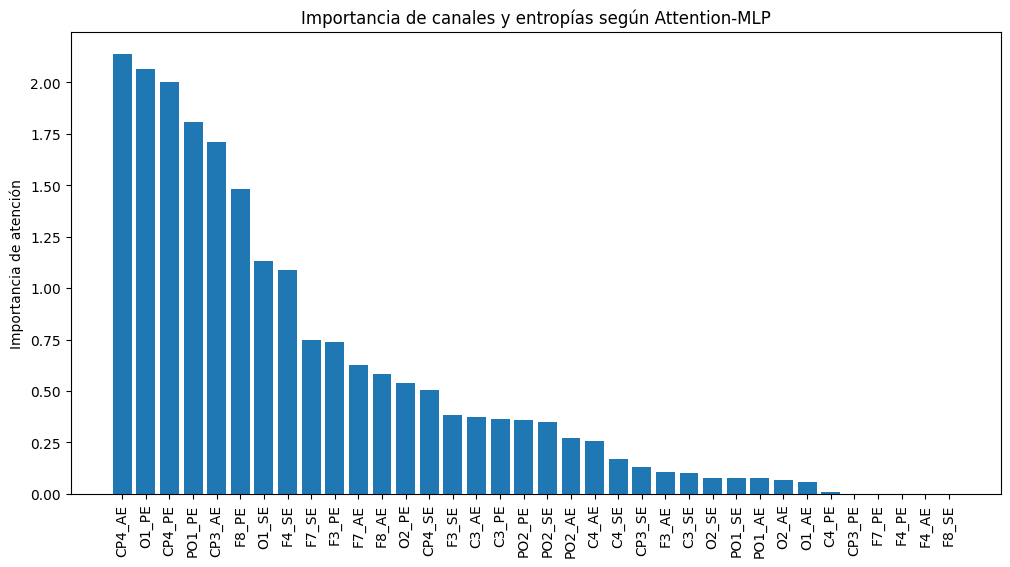

In [ ]:
# Attention-based MLP
X_train, X_test, y_train, y_test = train_test_split(X_filtrado, y_filtrado, test_size=0.2, stratify=y_filtrado, random_state=42)

n_features = X_train.shape[1]
n_classes = len(np.unique(y_train))

y_train_cat = to_categorical(y_train, num_classes=n_classes)
y_test_cat = to_categorical(y_test, num_classes=n_classes)

# -Capa de atención
class FeatureAttention(Layer):
    def __init__(self, n_features, return_attention=False):
        super(FeatureAttention, self).__init__()
        self.attention_weights = Dense(n_features, activation='softmax')
        self.return_attention = return_attention

    def call(self, inputs):
        weights = self.attention_weights(inputs)
        weighted = Multiply()([inputs, weights])
        if self.return_attention:
            return weights
        else:
            return weighted

# Construcción del modelo
inputs = Input(shape=(n_features,))
x = Dense(n_features, activation='relu')(inputs)
attention_layer_output = FeatureAttention(n_features, return_attention=False)(x)

x = Dense(64, activation='relu')(attention_layer_output)
x = Dense(32, activation='relu')(x)
outputs = Dense(n_classes, activation='softmax')(x)

attention_model = Model(inputs, outputs)
attention_model.compile(optimizer=Adam(1e-3), loss='categorical_crossentropy', metrics=['accuracy'])

# Entrenamiento
history = attention_model.fit(X_train, y_train_cat, validation_data=(X_test, y_test_cat), epochs=30, batch_size=32, verbose=1)

# -Evaluación
y_pred = np.argmax(attention_model.predict(X_test), axis=1)
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))

# Extracción de pesos de atención
attention_weight_model = Model(inputs=attention_model.input, outputs=attention_model.layers[1].output)
attention_weights = attention_weight_model.predict(X_test)  # (n_samples, n_features)

# Promedio de pesos para obtener importancia global
importancia_global = np.mean(attention_weights, axis=0)

df_importancia = pd.DataFrame({
    "feature": colnames,
    "importancia": importancia_global
}).sort_values(by="importancia", ascending=False)

print(df_importancia)

plt.figure(figsize=(12,6))
plt.bar(df_importancia["feature"], df_importancia["importancia"])
plt.xticks(rotation=90)
plt.ylabel("Importancia de atención")
plt.title("Importancia de canales y entropías según Attention-MLP")
plt.show()

## Análisis DL2: Deep Learning
### En vez de utilizar las Entropías computadas, se utiliza los registros de EEG procesados en los electrodos seleccionados
- Convolutional Neural Network (CNN) con Long Short-Term Memory (LSTM)

In [ ]:
# Canales de interés
canales_objetivo = ["CP3", "C3", "C4", "CP4", "F3", "F7", "PO1", "O1", "PO2", "O2", "F4", "F8"]

def filtrar_canales(segmentos, canales_objetivo):
    """
    Filtra los segmentos para quedarse solo con los canales de interés.
    """
    segmentos_filtrados = {}
    for sujeto, info in segmentos.items():
        # Encontrar índices de los canales objetivo presentes en los datos
        indices = [info['canales'].index(ch) for ch in canales_objetivo if ch in info['canales']]
        # Filtrar cada epoch
        epochs_filtradas = [epoch[indices, :] for epoch in info['epochs']]
        # Guardar en nuevo diccionario
        segmentos_filtrados[sujeto] = {
            'epochs': epochs_filtradas,
            'tiempos': info['tiempos'],
            'fs': info['fs'],
            'canales': [info['canales'][i] for i in indices]
        }
    return segmentos_filtrados

# Aplicar filtro
segmentos_fatiga_filtrado = filtrar_canales(segmentos_fatiga, canales_objetivo)
segmentos_normal_filtrado = filtrar_canales(segmentos_normal, canales_objetivo)

# Verificar
print("canales filtrados:", segmentos_fatiga_filtrado[1]['canales'])

canales filtrados: ['CP3', 'C3', 'C4', 'CP4', 'F3', 'F7', 'PO1', 'O1', 'PO2', 'O2', 'F4', 'F8']


In [ ]:
# Combinar los datos en X, y
def crear_dataset(segmentos_fatiga, segmentos_normal):
    X = []
    y = []

    for sujeto, info in segmentos_fatiga.items():
        for epoch in info['epochs']:
            X.append(epoch.T)  # Transponer: (n_samples, n_canales) → (timesteps, features)
            y.append(1)        # Fatiga = 1

    for sujeto, info in segmentos_normal.items():
        for epoch in info['epochs']:
            X.append(epoch.T)
            y.append(0)        # Normal = 0

    X = np.array(X)
    y = np.array(y)
    return X, y

X, y = crear_dataset(segmentos_fatiga_filtrado, segmentos_normal_filtrado)
print("Shape X:", X.shape)  # (n_epochs_total, timesteps, n_canales)
print("Shape y:", y.shape)

# One-hot encoding
n_classes = len(np.unique(y))
y_cat = to_categorical(y, num_classes=n_classes)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y_cat, test_size=0.2, stratify=y, random_state=42)

Shape X: (8640, 1000, 12)
Shape y: (8640,)


In [ ]:
n_timesteps = X_train.shape[1]
n_features = X_train.shape[2]

model = Sequential()

# CNN para extracción de características locales
model.add(Conv1D(filters=32, kernel_size=3, activation='relu', input_shape=(n_timesteps, n_features)))
model.add(BatchNormalization())
model.add(MaxPooling1D(pool_size=2))
model.add(Dropout(0.3))

model.add(Conv1D(filters=64, kernel_size=3, activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling1D(pool_size=2))
model.add(Dropout(0.3))

# LSTM para captura de dependencia temporal
model.add(LSTM(64, return_sequences=False))
model.add(Dropout(0.3))

# Salida
model.add(Dense(n_classes, activation='softmax'))

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                 │ (None, 998, 32)        │         1,184 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 998, 32)        │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 499, 32)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 499, 32)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 497, 64)        │         6,208 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 497, 64)        │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_1 (MaxPooling1D)  │ (None, 248, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 248, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 64)             │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 2)              │           130 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 40,930 (159.88 KB)

 Trainable params: 40,738 (159.13 KB)

 Non-trainable params: 192 (768.00 B)

In [ ]:
history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=50,
    batch_size=32,
    verbose=1
)

Epoch 1/50
216/216 ━━━━━━━━━━━━━━━━━━━━ 46s 200ms/step - accuracy: 0.5132 - loss: 0.7106 - val_accuracy: 0.5527 - val_loss: 0.6803
Epoch 2/50
216/216 ━━━━━━━━━━━━━━━━━━━━ 43s 197ms/step - accuracy: 0.5601 - loss: 0.6828 - val_accuracy: 0.5862 - val_loss: 0.6743
Epoch 3/50
216/216 ━━━━━━━━━━━━━━━━━━━━ 85s 210ms/step - accuracy: 0.5872 - loss: 0.6734 - val_accuracy: 0.5758 - val_loss: 0.6684
Epoch 4/50
216/216 ━━━━━━━━━━━━━━━━━━━━ 80s 200ms/step - accuracy: 0.5945 - loss: 0.6641 - val_accuracy: 0.5712 - val_loss: 0.6708
Epoch 5/50
216/216 ━━━━━━━━━━━━━━━━━━━━ 84s 207ms/step - accuracy: 0.5810 - loss: 0.6664 - val_accuracy: 0.5984 - val_loss: 0.6602
Epoch 6/50
216/216 ━━━━━━━━━━━━━━━━━━━━ 43s 197ms/step - accuracy: 0.5823 - loss: 0.6687 - val_accuracy: 0.5833 - val_loss: 0.6657
Epoch 7/50
216/216 ━━━━━━━━━━━━━━━━━━━━ 82s 199ms/step - accuracy: 0.6005 - loss: 0.6577 - val_accuracy: 0.5694 - val_loss: 0.6715
Epoch 8/50
216/216 ━━━━━━━━━━━━━━━━━━━━ 82s 198ms/step - accuracy: 0.5945 - loss: 0

In [ ]:
y_pred_prob = model.predict(X_test) # Podemos utilizar estas probabilidades, en vez de hacerlo directamente binario.
y_pred = np.argmax(y_pred_prob, axis=1)
y_true = np.argmax(y_test, axis=1)

print("Accuracy:", accuracy_score(y_true, y_pred))
print("Classification Report:\n", classification_report(y_true, y_pred))

54/54 ━━━━━━━━━━━━━━━━━━━━ 3s 64ms/step
Accuracy: 0.6585648148148148
Classification Report:
               precision    recall  f1-score   support

           0       0.69      0.58      0.63       864
           1       0.64      0.74      0.68       864

    accuracy                           0.66      1728
   macro avg       0.66      0.66      0.66      1728
weighted avg       0.66      0.66      0.66      1728



In [ ]:
history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=100,
    batch_size=32,
    verbose=1
)

Epoch 1/100
216/216 ━━━━━━━━━━━━━━━━━━━━ 61s 236ms/step - accuracy: 0.5422 - loss: 0.7041 - val_accuracy: 0.5793 - val_loss: 0.6725
Epoch 2/100
216/216 ━━━━━━━━━━━━━━━━━━━━ 80s 230ms/step - accuracy: 0.5567 - loss: 0.6863 - val_accuracy: 0.5544 - val_loss: 0.6842
Epoch 3/100
216/216 ━━━━━━━━━━━━━━━━━━━━ 82s 228ms/step - accuracy: 0.5902 - loss: 0.6665 - val_accuracy: 0.5903 - val_loss: 0.6681
Epoch 4/100
216/216 ━━━━━━━━━━━━━━━━━━━━ 82s 229ms/step - accuracy: 0.5816 - loss: 0.6687 - val_accuracy: 0.5793 - val_loss: 0.6736
Epoch 5/100
216/216 ━━━━━━━━━━━━━━━━━━━━ 82s 230ms/step - accuracy: 0.5780 - loss: 0.6663 - val_accuracy: 0.5712 - val_loss: 0.6778
Epoch 6/100
216/216 ━━━━━━━━━━━━━━━━━━━━ 85s 243ms/step - accuracy: 0.5920 - loss: 0.6602 - val_accuracy: 0.5741 - val_loss: 0.6593
Epoch 7/100
216/216 ━━━━━━━━━━━━━━━━━━━━ 80s 232ms/step - accuracy: 0.5938 - loss: 0.6615 - val_accuracy: 0.5926 - val_loss: 0.6613
Epoch 8/100
216/216 ━━━━━━━━━━━━━━━━━━━━ 85s 245ms/step - accuracy: 0.6010 -

In [ ]:
y_pred_prob = model.predict(X_test) # Podemos utilizar estas probabilidades, en vez de hacerlo directamente binario.
y_pred = np.argmax(y_pred_prob, axis=1)
y_true = np.argmax(y_test, axis=1)

print("Accuracy:", accuracy_score(y_true, y_pred))
print("Classification Report:\n", classification_report(y_true, y_pred))

54/54 ━━━━━━━━━━━━━━━━━━━━ 4s 62ms/step
Accuracy: 0.7575231481481481
Classification Report:
               precision    recall  f1-score   support

           0       0.72      0.83      0.77       864
           1       0.80      0.68      0.74       864

    accuracy                           0.76      1728
   macro avg       0.76      0.76      0.76      1728
weighted avg       0.76      0.76      0.76      1728



In [ ]:
# Guardar el modelo completo
model.save("cnn_lstm_eeg_model2.h5")

#model_cargado = load_model("cnn_lstm_eeg_model.h5")